# Inferring parameters for the ToR-ORd model

In this notebook, we use PINTS to create noisy data for a ToR-ORd [$^{[1]}$](#Sources) system and then perform inference on the model
to try and retrieve the parameters. This should be compared with results from other notebooks, such as the FitzHugh-Nagumo and Beeler-Reuter
notebooks. For further analysis and plots, see `torord_further_analysis.ipynb`.

## Creating the ForwardModel

### Variable descriptions

We need to set up the ODE system first. This is a large system and so we will not go through all the equations and varibles,
but we will give a description of all the currents and fluxes in the model and the important parameters (to be inferred).

|variable|description|ions|
|---|-------|---|
|$V$|membrane potential|all|
|$I_{Na}$|fast sodium current|$Na^{+}$|
|$I_{NaL}$|late sodium current|$Na^{+}$|
|$I_{to}$|transient outward potassium current|$K^{+}$|
|$I_{CaL}$|L-type calcium current|$Ca^{2+}$|
|$I_{K_r}$|rapid delayed rectifier potassium current|$K^{+}$|
|$I_{K_s}$|slow delayed rectifier potassium current|$K^{+}$|
|$I_{K_1}$|inward rectifier current|$K^{+}$|
|$I_{NaCa}$|sodium/calcium exchanger (NCX)|$Na^{+}$, $Ca^{2+}$|
|$I_{NaK}$|sodium/potassium pump|$Na^{+}$, $K^{+}$|
|$I_{Kb}$|background potassium current|$K^{+}$|
|$I_{Nab}$|background sodium current|$Na^{+}$|
|$I_{Cab}$|background calcium current|$Ca^{2+}$|
|$I_{pCa}$|calcium pump|$Ca^{2+}$|
|$I_{ClCa}$|calcium-sensitive chloride current|$Cl^{-}$|
|$I_{Clb}$|background chloride current|$Cl^{-}$|
|$J_{rel}$|calcium flux through ryanodine receptor|$Ca^{2+}$|
|$J_{up}$|calcium uptake into network sarcoplasmic reticulum via SERCA|$Ca^{2+}$|
|$J_{leak}$|calcium leak out of network sarcoplasmic reticulum|$Ca^{2+}$|
|$J_{tr}$|calcium NSR to JSR calcium translocation|$Ca^{2+}$|
|$J_{diff,Na}$|sodium diffusion flux between myoplasm and subspace|$Na^{+}$|
|$J_{diff,K}$|potassium diffusion flux between myoplasm and subspace|$K^{+}$|
|$J_{diff}$|calcium diffusion flux between myoplasm and subspace|$Ca^{2+}$|
|CMDN|calmodulin buffer|$Ca^{2+}$|
|TRPN|troponin buffer|$Ca^{2+}$|
|CSQN|calsequestrin buffer|$Ca^{2+}$|
|BSR|anionic sarcoplasmic reticulum binding sites for calcium|$Ca^{2+}$|
|BSL|anionic sarcolemmal binding sites for calcium|$Ca^{2+}$|
|CaMKII|calmodulin-dependent protein kinase II|$Ca^{2+}$|

We will not go into any major detail with the equations, but the main membrane potential ODE is a sum of all the above
currents added to a stimulating current, $I_{stim}$ which provides the action potential shape. We also note here that the
ToR-ORd model has $43$ time dependent variables forming a system of $43$ ordinary differential equations.

|variable group|list of variables|ions|
|---|---|---|
|Membrane potential|$V$|all|
|Ion compartment concentrations|$[Na]_{i}, [Na]_{ss}, [K]_{i}, [K]_{ss}, [Ca]_{i}, [Ca]_{ss}, [Ca]_{nsr}, [Ca]_{jsr}$|$Na^{+}, K^{+}, Ca^{2+}$|
|$I_{Na}$ gating variables|$m, h_{p}, h, j, j_{p}$|$Na^{+}$|
|$I_{NaL}$ gating variables|$m_L, h_L, h_{Lp}$|$Na^{+}$|
|$I_{to}$ gating variables|$a, i_{F}, i_{S}, a_{p}, i_{Fp}, i_{Sp}$|$K^{+}$|
|$I_{CaL}$ gating variables|$d, f_{f}, f_{s}, f_{caf}, f_{cas}, j_{ca}, n_{ca}, n_{cai}, f_{fp}, f_{cafp}$|$K^{+}$|
|$I_{K_r}$ gating variables|$C_{0}, C_{1}, C_{2}, O, I$|$K^{+}$|
|$I_{K_s}$ gating variables|$x_{s1}, x_{s2}$|$K^{+}$|
|$J_{rel}$|$J_{relp}, J_{relnp}$|$Ca^{2+}$|
|CaMKII buffer|$CaMK_{t}$|$Ca^{2+}$|

### Initial conditions

We will use the following initial conditions, representing an endocardial cell.

In [1]:
initial_conditions = [-88.8691566357934,12.0996647655188,12.1000028563765,142.412524737626,142.412481425842,7.45541572746214e-05,
                      6.50418928341426e-05,1.53037019085812,1.52803094224238,0.000787657400526199,0.674096901201792,0.830658198588696,
                      0.830466744399495,0.830093612199637,0.000159670117055769,0.528261721740178,0.288775833197764,0.000944249645410894,
                      0.999616956857814,0.593680589620082,0.000481107253796778,0.999616964658062,0.654092074678260,8.86091322819384e-29,
                      0.999999992783113,0.938965241412012,0.999999992783179,0.999900458262832,0.999977476316330,0.000492094765239740,
                      0.000833711885764158,0.999999992566681,0.999999992766279,0.247156543918935,0.000175017075236424,3.90843796133124e-24,
                      0.0110752904836162,0.998073652444028,0.000844745297078649,0.000698171876592920,0.000370404872169913,1.30239063420973e-05,
                      -1.88428892080206e-22]

In [2]:
import pints
import numpy as np
import scipy.integrate as si
import nbkode
import matplotlib.pyplot as plt
import pandas as pd
from numba import jit

from torord_rhs import ToRORdRHS
import torord_rhs_new

### PINTS implementation of the model

In addition to implementing the system, we give the option in the class to specify fixed parameters, if we wish to 
reduce the dimensions of the parameter space. Additionally, as we realistically would only be able to measure the membrane potential,
$V$, and the calcium concentration, $c$, we will use these as the only outputs of the system.

The system of equations from the model have been adapted from the original MATLAB code from the ToR-ORd github repository [$^{[5]}$](#Sources).

In [3]:
import time

In [4]:
class ToRORdModel(pints.ForwardModel):

    def __init__(self, initial_conditions, stimulating_current, fixed_params=None, outputs=["V", "c"],
                 rtol=10**(-3), atol=10**(-6)):
        """Initialises the forward model with certain fixed parameters passed to the method
        as key-value pairs.
        """
        super(ToRORdModel, self).__init__()
        assert len(initial_conditions) == 43
        self._initial_conditions = initial_conditions
        # The current conditions represent the state of the model after one beat
        self._current_conditions = initial_conditions
        self._reset_model = True

        assert len(stimulating_current) == 2
        self._stim_duration, self._stim_amplitude = tuple(stimulating_current)
        self._param_names = ["$G_{Na}$", "$P_{Cab}$", "$G_{Kr}$", "$G_{ClCa}$", "$G_{Clb}$", "$G_{to}$"]
        self._variable_names = ["V", "Na_i", "Na_ss", "K_i", "K_ss", "Ca_i", "Ca_ss", "Ca_nsr", "Ca_jsr",
                                "m", "hp", "h", "j", "jp",
                                "mL", "hL", "hLp",
                                "a", "iF", "iS", "ap", "iFp", "iSp",
                                "d", "ff", "fs", "fcaf", "fcas", "jca", "nca", "nca_i", "ffp", "fcafp",
                                "xs1", "xs2",
                                "Jrel_np", "CaMKt",
                                "ikr_c0", "ikr_c1", "ikr_c2", "ikr_o", "ikr_i",
                                "Jrel_p"]
        self._fixed_params = {}
        if fixed_params is not None:
            for k in fixed_params.keys():
                if k in self._param_names:
                    self._fixed_params[k] = fixed_params[k]

        assert 1 <= len(outputs) <= 43
        assert set(outputs).issubset(set(self._variable_names))
        self._outputs = outputs
        self._rtol = rtol
        self._atol = atol
        # If we wish to specific current or flux multipliers, we do so in the dict below (e.g. for blocking channels)
        self.multipliers = {"I_CaL": 1, "I_Na": 1, "I_to": 1, "I_NaL": 1, "I_Kr": 1, "I_Ks": 1, "I_K1": 1, "I_Kb": 1,
                             "I_NaCa": 1, "I_NaK": 1, "I_Nab": 1, "I_Cab": 1, "I_pCa": 1, "I_CaCl": 1, "I_Clb": 1,
                             "J_rel": 1, "J_up": 1}
        # If we wish to change the extracellular concentrations or subspace fractions, we do so here
        self.concs_and_fractions = {"Na_o": 140.0, "Ca_o": 1.8, "K_o": 5.0, "ICaL_fractionSS": 0.8, "INaCa_fractionSS": 0.35}

    def get_param_names(self):
        """Returns the parameter names.
        """
        return self._param_names

    def get_unfixed_param_names(self):
        """Returns the unfixed parameters
        """
        output_list = self._param_names.copy()
        for fixed_param in self._fixed_params.keys():
            output_list.remove(fixed_param)
        return output_list

    def n_outputs(self):
        """Returns number of model outputs, default to just V and c
        """
        return len(self._outputs)

    def n_parameters(self):
        """Returns number of parameters to be inferred, i.e. all non-fixed parameters.
        """
        return len(self._param_names) - len(self._fixed_params)

    def n_fixed_parameters(self):
        """Returns number of parameters we fix.
        """
        return len(self._fixed_params)

    def simulate(self, parameters, times):
        """This inherits from pints.ForwardModel, performs one forward simulation of the model.
        The list `parameters` contains only the parameters we are inferring.
        """
        G_Na, P_Cab, G_Kr, G_ClCa, G_Clb, G_to = self._get_all_params(parameters)
        t_span = [times[0], times[len(times) - 1]]
        
        # For the line below, our starting state will either be the true initial conditions,
        # or the conditions of the model at the end of the last heartbeat
        y0 = self._initial_conditions if self._reset_model else self._current_conditions        
        # start = time.process_time()
        sol = si.odeint(func=self._rhs, y0=y0, t=times, 
                        args=(G_Na, P_Cab, G_Kr, G_ClCa, G_Clb, G_to,
                              self._stim_duration, self._stim_amplitude, 
                              np.array(list(self.multipliers.values())), 
                              np.array(list(self.concs_and_fractions.values()))),
                        rtol=self._rtol, atol=self._atol)
        # sol = si.solve_ivp(fun=self._rhs, y0=y0, t_span=t_span, t_eval=times, 
        #                    args=(G_Na, P_Cab, G_Kr, G_ClCa, G_Clb,
        #                          self._stim_duration, self._stim_amplitude, 
        #                          self.multipliers, self.concs_and_fractions),
        #                    rtol=self._rtol, atol=self._atol, method="BDF")
        # print(time.process_time() - start)
        # Update the current conditions
        self._current_conditions = sol[-1, :]

        # Now we find which outputs we wish to use
        output_indices = [self._variable_names.index(variable) for variable in self._outputs]
        return np.array([sol[:, index] for index in output_indices]).transpose()

    def simulate_beats(self, parameters, times, num_beats, num_saved_beats=1):
        """This method imitates how ToR-ORd is initially run, by starting with some arbitrary initial conditions
        and then simulating a number of beats to get the model into an oscillatory state. This is the only time
        in which reset_model flag is set to False, as we wish for a continuous set of beats.
        """
        self._reset_model = False
        output_list = []
        for beat in range(num_beats):
            print(beat, end='_/\_')
            data = self.simulate(parameters, times)
            if num_beats - beat <= num_saved_beats:
                output_list.append(data)
        self._reset_model = True
        return np.vstack(output_list)

    def _get_all_params(self, parameters):
        """We need a list of 6 parameters, so we check to see which parameters are fixed, and which are not.
        We increment j each time a non-fixed parameter is reached.
        """
        all_parameters = []
        j = 0
        for param in self._param_names:
            if param in self._fixed_params.keys():
                all_parameters.append(self._fixed_params[param])
            else:
                all_parameters.append(parameters[j])
                j += 1
        return tuple(all_parameters)

    @staticmethod
    @jit
    def _rhs(y, t, G_Na, P_Cab, G_Kr, G_ClCa, G_Clb, G_to, stim_duration, stim_amplitude, multipliers, concs_and_fractions):
        """The right hand side function of the ToR-ORd system. This is in a separate file as it is 
        a very long system of equations.
        """
        # rhs = ToRORdRHS(t, y, G_Na, P_Cab, G_Kr, G_ClCa, G_Clb, stim_duration, stim_amplitude, multipliers, concs_and_fractions)
        rhs = torord_rhs_new.evaluate(t, y, G_Na, P_Cab, G_Kr, G_ClCa, G_Clb, G_to, stim_duration, stim_amplitude, 
                                      multipliers, concs_and_fractions)
        return np.array(rhs)

    # @staticmethod
    # def _rhs(t, y, params):
    #     """The right hand side function of the ToR-ORd system. This is in a separate file as it is 
    #     a very long system of equations.
    #     """
    #     G_Na, P_Cab, G_Kr, G_ClCa, G_Clb, stim_duration, stim_amplitude, multipliers, concs_and_fractions = params
    #     rhs = ToRORdRHS(t, y, G_Na, P_Cab, G_Kr, G_ClCa, G_Clb, stim_duration, stim_amplitude, multipliers, concs_and_fractions)
    #     return np.array(rhs.evaluate())

<>:111: SyntaxWarning: invalid escape sequence '\_'
<>:111: SyntaxWarning: invalid escape sequence '\_'
C:\Users\matth\AppData\Local\Temp\ipykernel_15308\2315734976.py:111: SyntaxWarning: invalid escape sequence '\_'
  print(beat, end='_/\_')


## Generating data for the model

### Simulating the system

All of the currents have corresponding conductances, and the fluxes have corresponding multipliers. The conductances we will
be most interested in for the purpose of inference are listed in the table below.

|conductance|ToR-ORd value [$^{[1]}$](#Sources)|ion|reasoning for inference|
|---|---|---|-------|
|$G_{Na}$|$11.7802$|$Na^{+}$|Multiple changes were made: the Grandi [$^{[2]}$](#Sources) model was used with ORd [$^{[3]}$](#Sources) CaMKII phosphorylation.|
|$P_{Cab}$|$8.3757 \times 10^{-5}$|$Ca^{2+}$|The L-type calcium current had the largest revision of them all compared to the ORd model.|
|$G_{K_r}$|$0.0321$|$K^{+}$|This was changed to have a Markovian [$^{[4]}$](#Sources) formulation, as originally parameter inference could not fit the action potential.|
|$G_{ClCa}$|$0.2843$|$Cl^{-}$|This current was added for the purpose of fitting to the shape of the action potential.|
|$G_{Clb}$|$0.00198$|$Cl^{-}$|This current was added for the purpose of fitting to the shape of the action potential.|
|$G_{to}$|$0.16$|$K^{+}$|---|

Next, we will generate some data for the model using known parameter values. We will use the final parameter values achieved by
Tomek et al. [$^{[1]}$](#Sources) in the table above. Additionally, we will use their stimulation parameters of `stim_amplitude = -53` and
`stim_duration = 1`.

In [6]:
# Here we choose which parameters to fix in the simulation
# fixed_params = {"$G_{Na}$": 11.7802, "$G_{Clb}$": 0.00198, "$G_{to}$": 0.16}
fixed_params = {"$G_{Clb}$": 0.00198, "$G_{to}$": 0.16}
# fixed_params = {"$G_{Na}$": 11.7802, "$G_{Clb}$": 0.00198}
# fixed_params = {"$G_{Clb}$": 0.00198}
# fixed_params = None
# Stimulation parameters [stim_duration, stim_amplitude]
stim_params = [1, -53]

In [7]:
model = ToRORdModel(initial_conditions, stim_params, fixed_params=fixed_params, outputs=["V", "Ca_i"], rtol=10**(-8), atol=10**(-8))
param_names = model.get_unfixed_param_names()
print(param_names)
# parameters = np.array([8.3757e-5, 0.0321, 0.2843])
# parameters = np.array([8.3757e-5, 0.0321, 0.2843, 0.16])
parameters = np.array([11.7802, 8.3757e-5, 0.0321, 0.2843])
# parameters = np.array([11.7802, 8.3757e-5, 0.0321, 0.2843, 0.16])
times = np.arange(0, 1000, 2)

['$G_{Na}$', '$P_{Cab}$', '$G_{Kr}$', '$G_{ClCa}$']


In [8]:
output_param_df = pd.DataFrame({"true": parameters})

### Adding noise to the system

We now utilise PINTS noise generators to create some noisy data for the system. Specifically, `pints.noise.independent`
creates independent Gaussian noise iid $\mathcal{N}(0, \sigma)$.

In [9]:
def generate_data(model, parameters, times, sigma, file_loc, columns=["V", "Ca_i"]):
    data = model.simulate(parameters, times)
    noisy_data = data + pints.noise.independent(sigma, data.shape)
    noisy_df = pd.DataFrame(noisy_data, columns=columns)
    noisy_df.to_csv(file_loc)
    return data

In [52]:
data = generate_data(model, parameters, times, np.array([1, 3e-6]), "simulation_outputs/noisy_data.csv")

0.0


### Plotting time series

In [10]:
import matplotlib.pyplot as plt

In [20]:
noisy_data = pd.read_csv("simulation_outputs/noisy_data.csv", index_col=0).to_numpy()
# noisy_V = noisy_data[:, 0]
V, Ca = data[:, 0], data[:, 1]

In [21]:
def plot_V(times, V, noisy_V, title, save=False):
    plt.plot(times, V, "-r", label="Without noise")
    plt.plot(times, noisy_V, "-b", alpha=0.5, label="With noise")
    plt.xlabel("Time [ms]")
    plt.ylabel("Potential [mV]")
    plt.legend()
    plt.title(f"Membrane potential {title}")
    if save:
        plt.savefig(f"simulation_outputs/{title}/time_series_V.png")

In [22]:
def plot_Ca(times, Ca, noisy_Ca, title, save=False):
    plt.plot(times, Ca, "-r", label="Without noise")
    plt.plot(times, noisy_Ca, "-b", alpha=0.5, label="With noise")
    plt.xlabel("Time [ms]")
    plt.ylabel("Concentration [1e-7 mol/L]")
    plt.legend()
    plt.title(f"Ca2+ concentration {title}")
    if save:
        plt.savefig(f"simulation_outputs/{title}/time_series_Ca.png")

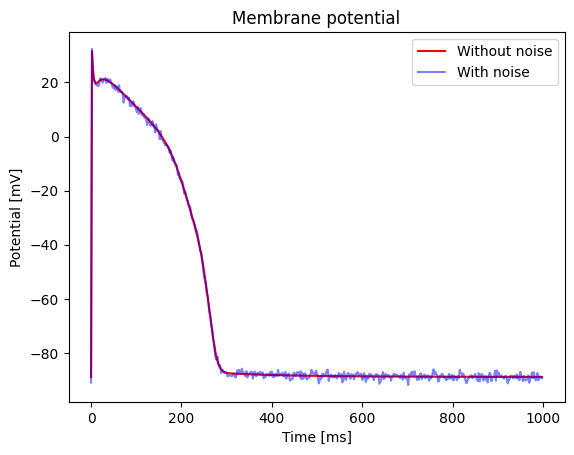

In [23]:
# V = data[:, 0]
noisy_V, noisy_Ca = noisy_data[:, 0], noisy_data[:, 1]
plt.plot(times, V, "-r", label="Without noise")
plt.plot(times, noisy_V, "-b", alpha=0.5, label="With noise")
plt.xlabel("Time [ms]")
plt.ylabel("Potential [mV]")
plt.legend()
plt.title("Membrane potential")
plt.savefig("simulation_outputs/time_series_V.png")

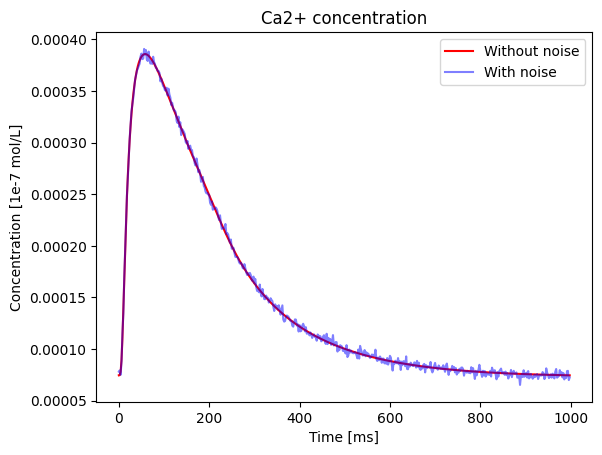

In [24]:
plt.plot(times, Ca, "-r", label="Without noise")
plt.plot(times, noisy_Ca, "-b", alpha=0.5, label="With noise")
plt.xlabel("Time [ms]")
plt.ylabel("Concentration [1e-7 mol/L]")
plt.legend()
plt.title("Ca2+ concentration")
plt.savefig("simulation_outputs/time_series_c.png")

### Simulating multiple beats

Our model also has the ability to simulate multiple continuous beats, as in the original ToR-ORd model [$^{[5]}$](#Sources). We will do this for $100$ beats
and then plot the last $5$ as a demonstration.

In [171]:
multiple_beats_data = model.simulate_beats(parameters, times, num_beats=100, num_saved_beats=5)

0_/\_1_/\_2_/\_3_/\_4_/\_5_/\_6_/\_7_/\_8_/\_9_/\_10_/\_11_/\_12_/\_13_/\_14_/\_15_/\_16_/\_17_/\_18_/\_19_/\_20_/\_21_/\_22_/\_23_/\_24_/\_25_/\_26_/\_27_/\_28_/\_29_/\_30_/\_31_/\_32_/\_33_/\_34_/\_35_/\_36_/\_37_/\_38_/\_39_/\_40_/\_41_/\_42_/\_43_/\_44_/\_45_/\_46_/\_47_/\_48_/\_49_/\_50_/\_51_/\_52_/\_53_/\_54_/\_55_/\_56_/\_57_/\_58_/\_59_/\_60_/\_61_/\_62_/\_63_/\_64_/\_65_/\_66_/\_67_/\_68_/\_69_/\_70_/\_71_/\_72_/\_73_/\_74_/\_75_/\_76_/\_77_/\_78_/\_79_/\_80_/\_81_/\_82_/\_83_/\_84_/\_85_/\_86_/\_87_/\_88_/\_89_/\_90_/\_91_/\_92_/\_93_/\_94_/\_95_/\_96_/\_97_/\_98_/\_99_/\_

In [24]:
multiple_beats_df = pd.DataFrame(multiple_beats_data, columns=["V", "Ca_i"])
multiple_beats_df.to_csv("simulation_outputs/multiple_beats.csv")

In [25]:
multiple_beats_data = pd.read_csv("simulation_outputs/multiple_beats.csv", index_col=0).to_numpy()
mult_V, mult_Ca = multiple_beats_data[:, 0], multiple_beats_data[:, 1]

In [26]:
mult_times = np.arange(0, 5000, 2)

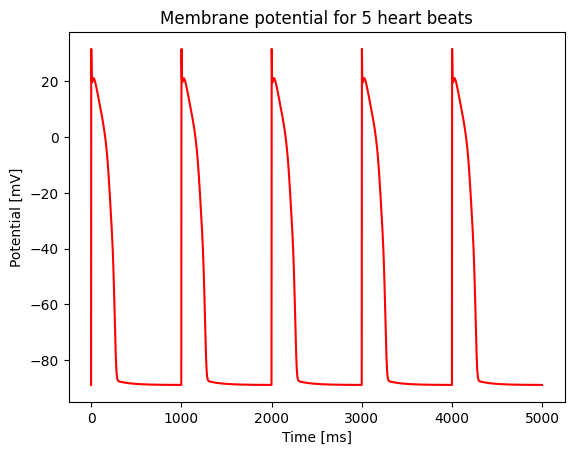

In [27]:
plt.plot(mult_times, mult_V, "-r")
plt.xlabel("Time [ms]")
plt.ylabel("Potential [mV]")
plt.title("Membrane potential for 5 heart beats")
plt.savefig("simulation_outputs/multiple_beats_V.png")

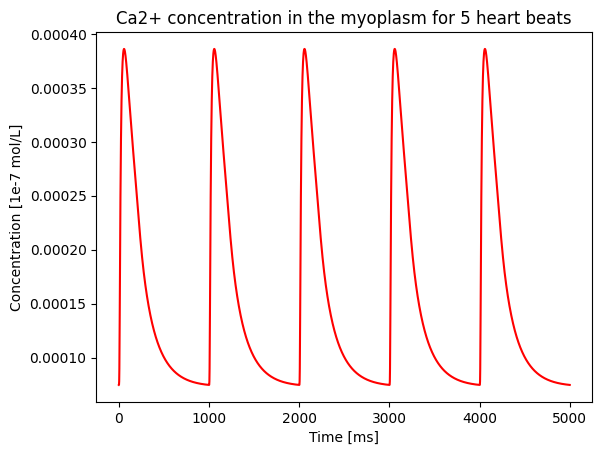

In [28]:
plt.plot(mult_times, mult_Ca, "-r")
plt.xlabel("Time [ms]")
plt.ylabel("Concentration [1e-7 mol/L]")
plt.title("Ca2+ concentration in the myoplasm for 5 heart beats")
plt.savefig("simulation_outputs/multiple_beats_Ca.png")

## Optimisation

### Setting up our error measure

The next main goal is to use objectives from the ToR-ORd genetic algorithm (see appendix 2 in [$^{[1]}$](#Sources)) within
an error measure to be optimised and from which we can perform inference. This will also dictate
our choice of likelihood function for that inference.

Below, we list the main aims of the genetic algorithm as they appear in the paper, and our interpretation going forward with the error measure. Note that although these were fused into a multicriterial function, we will simply sum their normalised contributions into a single scalar error measure.

|Objective description|Model setup|Error term|Contribution to error measure|
|------------|-----|----|------------|
|"similarity of action potential morphology to the reference."[$^{[1]}$](#Sources)|Default|$\mathcal{E}_{APD}$|Normalised square error of APD90 values.|
|"calcium transient amplitude"[$^{[1]}$](#Sources)|Default|$\mathcal{E}_{CaTA}$|Normalised square error of calcium transient amplitudes.|
|"calcium transient duration"[$^{[1]}$](#Sources)|Default|$\mathcal{E}_{CaTD}$|Normalised square error of calcium transient duration from peak to 90% recovery.|
|"calcium transient amplitude reduction with sodium blockade"[$^{[1]}$](#Sources)|50% block of $I_{Na}$ and $I_{NaL}$|$\mathcal{E}_{BINa}$|$0$ if reduction is successful, $1$ otherwise.|
|"action potential duration reduction with calcium blockade"[$^{[1]}$](#Sources)|50% block of $I_{CaL}$|$\mathcal{E}_{BICaL}$|$0$ if reduction is successful, $1$ otherwise.|
|"depolarisation with $I_{K1}$ block"[$^{[1]}$](#Sources)|50% block of $I_{K_1}$|$\mathcal{E}_{BIK1}$|$0$ if the magnitude of the final potential is reduced, $1$ otherwise.|

Our first job is to set up all of the different model conditions listed in the table. Before we do this, we will pre-pace the
default model for $130$ beats, as done in[$^{[1]}$](#Sources).

Additionally, in the model code[$^{[5]}$](#Sources), APD90 is defined to be the time taken between peak potential and 90% reduction in amplitude. Our error measure will then be

\begin{equation}
    \mathcal{E} = \mathcal{E}_{APD} + \mathcal{E}_{CaTA} + \mathcal{E}_{CaTD} + \mathcal{E}_{BINa} + \mathcal{E}_{BICaL} + \mathcal{E}_{BIK1}.
\end{equation}

In [11]:
def pre_pace(model, parameters, times, num_beats, num_saved_beats):
    data = model.simulate_beats(parameters, times, num_beats=num_beats, num_saved_beats=num_saved_beats)
    current_conditions = model._current_conditions
    model._initial_conditions = current_conditions
    return current_conditions

In [30]:
conditions_130 = pre_pace(model, parameters, times, num_beats=130, num_saved_beats=1)

0_/\_1_/\_2_/\_3_/\_4_/\_5_/\_6_/\_7_/\_8_/\_9_/\_10_/\_11_/\_12_/\_13_/\_14_/\_15_/\_16_/\_17_/\_18_/\_19_/\_20_/\_21_/\_22_/\_23_/\_24_/\_25_/\_26_/\_27_/\_28_/\_29_/\_30_/\_31_/\_32_/\_33_/\_34_/\_35_/\_36_/\_37_/\_38_/\_39_/\_40_/\_41_/\_42_/\_43_/\_44_/\_45_/\_46_/\_47_/\_48_/\_49_/\_50_/\_51_/\_52_/\_53_/\_54_/\_55_/\_56_/\_57_/\_58_/\_59_/\_60_/\_61_/\_62_/\_63_/\_64_/\_65_/\_66_/\_67_/\_68_/\_69_/\_70_/\_71_/\_72_/\_73_/\_74_/\_75_/\_76_/\_77_/\_78_/\_79_/\_80_/\_81_/\_82_/\_83_/\_84_/\_85_/\_86_/\_87_/\_88_/\_89_/\_90_/\_91_/\_92_/\_93_/\_94_/\_95_/\_96_/\_97_/\_98_/\_99_/\_100_/\_101_/\_102_/\_103_/\_104_/\_105_/\_106_/\_107_/\_108_/\_109_/\_110_/\_111_/\_112_/\_113_/\_114_/\_115_/\_116_/\_117_/\_118_/\_119_/\_120_/\_121_/\_122_/\_123_/\_124_/\_125_/\_126_/\_127_/\_128_/\_129_/\_

In [12]:
model_default = model
model_BINa = ToRORdModel(model._initial_conditions, stim_params, fixed_params=fixed_params, outputs=["V", "Ca_i"], rtol=10**(-8), atol=10**(-8))
model_BINa.multipliers["I_Na"] = 0.5
model_BINa.multipliers["I_NaL"] = 0.5
model_BICaL = ToRORdModel(model._initial_conditions, stim_params, fixed_params=fixed_params, outputs=["V", "Ca_i"], rtol=10**(-8), atol=10**(-8))
model_BICaL.multipliers["I_CaL"] = 0.5
model_BIK1 = ToRORdModel(model._initial_conditions, stim_params, fixed_params=fixed_params, outputs=["V", "Ca_i"], rtol=10**(-8), atol=10**(-8))
model_BIK1.multipliers["I_K1"] = 0.5

Here, we will pre-pace for a further $20$ beats[$^{[1]}$](#Sources) to get these conditions up to a good starting position.

In [32]:
pre_pace(model, parameters, times, num_beats=20, num_saved_beats=1)
pre_pace(model_BINa, parameters, times, num_beats=20, num_saved_beats=1)
pre_pace(model_BICaL, parameters, times, num_beats=20, num_saved_beats=1)
pre_pace(model_BIK1, parameters, times, num_beats=20, num_saved_beats=1)

0_/\_1_/\_2_/\_3_/\_4_/\_5_/\_6_/\_7_/\_8_/\_9_/\_10_/\_11_/\_12_/\_13_/\_14_/\_15_/\_16_/\_17_/\_18_/\_19_/\_0_/\_1_/\_2_/\_3_/\_4_/\_5_/\_6_/\_7_/\_8_/\_9_/\_10_/\_11_/\_12_/\_13_/\_14_/\_15_/\_16_/\_17_/\_18_/\_19_/\_0_/\_1_/\_2_/\_3_/\_4_/\_5_/\_6_/\_7_/\_8_/\_9_/\_10_/\_11_/\_12_/\_13_/\_14_/\_15_/\_16_/\_17_/\_18_/\_19_/\_0_/\_1_/\_2_/\_3_/\_4_/\_5_/\_6_/\_7_/\_8_/\_9_/\_10_/\_11_/\_12_/\_13_/\_14_/\_15_/\_16_/\_17_/\_18_/\_19_/\_

array([-8.83494553e+01,  1.21182722e+01,  1.21186092e+01,  1.42888780e+02,
        1.42888736e+02,  7.41894908e-05,  6.47236861e-05,  1.52105029e+00,
        1.51865668e+00,  8.80813865e-04,  6.56927336e-01,  8.20082143e-01,
        8.19626167e-01,  8.18825391e-01,  1.76235448e-04,  5.07426510e-01,
        2.67922723e-01,  9.77922638e-04,  9.99580411e-01,  5.86061254e-01,
        4.98272311e-04,  9.99580428e-01,  6.43726126e-01,  5.64338990e-44,
        9.99999992e-01,  9.39730345e-01,  9.99999992e-01,  9.99901982e-01,
        9.99977537e-01,  4.82811847e-04,  8.18069531e-04,  9.99999992e-01,
        9.99999992e-01,  2.45432739e-01,  1.85579066e-04,  2.69992154e-38,
        1.09513051e-02,  9.97881006e-01,  8.76464732e-04,  7.30742260e-04,
        4.93920559e-04,  1.78650946e-05, -1.31925599e-33])

Save the pre-paced conditions.

In [33]:
default_df = pd.DataFrame({"ICs": model._initial_conditions})
BINa_df = pd.DataFrame({"ICs": model_BINa._initial_conditions})
BICaL_df = pd.DataFrame({"ICs": model_BICaL._initial_conditions})
BIK1_df = pd.DataFrame({"ICs": model_BIK1._initial_conditions})
default_df.to_csv("simulation_outputs/no block/ics_Na.csv")
BINa_df.to_csv("simulation_outputs/sodium block/ics_Na.csv")
BICaL_df.to_csv("simulation_outputs/calcium block/ics_Na.csv")
BIK1_df.to_csv("simulation_outputs/potassium block/ics_Na.csv")

Next we create problems for each model.

Save the noisy data below. This section should only be run once to generate the noisy data (provided it is valid).

In [36]:
data_default = generate_data(model, parameters, times, sigma=np.array([1, 3e-6]), file_loc="simulation_outputs/Na_noisy_data_default.csv")
data_BINa = generate_data(model_BINa, parameters, times, sigma=np.array([1, 3e-6]), file_loc="simulation_outputs/Na_noisy_data_BINa.csv")
data_BICaL = generate_data(model_BICaL, parameters, times, sigma=np.array([1, 3e-6]), file_loc="simulation_outputs/Na_noisy_data_BICaL.csv")
data_BIK1 = generate_data(model_BIK1, parameters, times, sigma=np.array([1, 3e-6]), file_loc="simulation_outputs/Na_noisy_data_BIK1.csv")

In [13]:
model._initial_conditions = pd.read_csv("simulation_outputs/no block/ics_Na.csv", index_col=0).to_numpy()[:, 0]
noisy_data = pd.read_csv("simulation_outputs/Na_noisy_data_default.csv", index_col=0).to_numpy()
problem = pints.MultiOutputProblem(model, times, noisy_data)
model_BINa._initial_conditions = pd.read_csv("simulation_outputs/sodium block/ics_Na.csv", index_col=0).to_numpy()[:, 0]
noisy_data_BINa = pd.read_csv("simulation_outputs/Na_noisy_data_BINa.csv", index_col=0).to_numpy()
problem_BINa = pints.MultiOutputProblem(model_BINa, times, noisy_data_BINa)
model_BICaL._initial_conditions = pd.read_csv("simulation_outputs/calcium block/ics_Na.csv", index_col=0).to_numpy()[:, 0]
noisy_data_BICaL = pd.read_csv("simulation_outputs/Na_noisy_data_BICaL.csv", index_col=0).to_numpy()
problem_BICaL = pints.MultiOutputProblem(model_BICaL, times, noisy_data_BICaL)
model_BIK1._initial_conditions = pd.read_csv("simulation_outputs/potassium block/ics_Na.csv", index_col=0).to_numpy()[:, 0]
noisy_data_BIK1 = pd.read_csv("simulation_outputs/Na_noisy_data_BIK1.csv", index_col=0).to_numpy()
problem_BIK1 = pints.MultiOutputProblem(model_BIK1, times, noisy_data_BIK1)

In [27]:
plot_V(times, data_BICaL[:, 0], noisy_data_BICaL[:, 0], "calcium block", save=False)

NameError: name 'data_BICaL' is not defined

Now we can override the `pints.ProblemErrorMeasure` class to implement our custom error measure.

In [14]:
from scipy.interpolate import make_smoothing_spline

In [15]:
class ToRORdErrorMeasure(pints.ProblemErrorMeasure):

    def __init__(self, problem, problem_BINa, problem_BICaL, problem_BIK1, normalisation=None, metrics="biomarkers"):
        """We have a similar initialisation process to the ProblemErrorMeasure class, but we also
        include our extra models with various blockages of ion channels to take into account in
        the error measure.
        """
        super(ToRORdErrorMeasure, self).__init__(problem)
        self._problem_BINa = problem_BINa
        self._problem_BICaL = problem_BICaL
        self._problem_BIK1 = problem_BIK1
        self._n_errors = 5 if metrics == "traces" else 6
        if normalisation is None or len(normalisation) != self._n_errors:
            normalisation = np.array([1] * self._n_errors)
        self._normalisation = np.array(normalisation)
        self._metrics = metrics
        # Calculate these true values to be used for later and as normalisation
        # constants in the likelihood function
        self.true_APD90 = self._get_duration_90(self._values[:, 0], spline=True)
        self.true_CaTA = np.max(self._values[:, 1]) - self._values[0, 1]
        self.true_CaTD90 = self._get_duration_90(self._values[:, 1], spline=True)

    def __call__(self, x):
        errors = self.get_errors(x)
        # print([errors[i] / self._normalisation[i]**2 for i in range(len(errors))])
        return sum(errors)

    def get_errors(self, x):
        data_default = self._problem.evaluate(x)
        data_BINa = self._problem_BINa.evaluate(x)
        data_BICaL = self._problem_BICaL.evaluate(x)
        data_BIK1 = self._problem_BIK1.evaluate(x)
        if self._metrics == "traces":
            errors = [self.error_AP_trace(data_default),
                      self.error_Ca_trace(data_default)]
        else:
            errors = [self.error_APD90(data_default),
                      self.error_CaTA(data_default), 
                      self.error_CaTD90(data_default)]
        errors += [self.error_INa_block(data_default, data_BINa), 
                   self.error_ICaL_block(data_default, data_BICaL), 
                   self.error_IK1_block(data_default, data_BIK1)]
        return np.array(errors) / self._normalisation**2

    def error_APD90(self, data):
        """Computes the true APD90 and compares it to APD90 with the current parameter set.
        """
        new_APD90 = self._get_duration_90(data[:, 0], spline=True)
        return (self.true_APD90 - new_APD90) ** 2 / self.true_APD90 ** 2

    def error_AP_trace(self, data):
        """Computes the mean squared error across the entire action potential trace. This is an alternative
        to calculating the APD90 value.
        """
        V = data[:, 0]
        V_hat = self._values[:, 0]
        return np.sum((V - V_hat)**2) / len(self._times)

    def error_CaTA(self, data):
        """Computes the true Ca2+ transient amplitude and compares it to the amplitude with the current parameter
        set.
        """
        new_CaTA = np.max(data[:, 1]) - data[0, 1]
        return (self.true_CaTA - new_CaTA) ** 2 / self.true_CaTA ** 2

    def error_CaTD90(self, data):
        """Computes the true Ca2+ transient duration for 90% reduction and compares it to the duration with the
        current parameter set.
        """
        new_CaTD90 = self._get_duration_90(data[:, 1], spline=True)
        return (self.true_CaTD90 - new_CaTD90) ** 2 / self.true_CaTD90 ** 2

    def error_Ca_trace(self, data):
        """Computes the normalised sum of squared errors across the entire calcium transient. This is an alternative
        to calculating the CaTA and CaTD90 values.
        """
        Ca = data[:, 1]
        Ca_hat = self._values[:, 1]
        return np.sum((Ca - Ca_hat)**2) / len(self._times)

    def error_INa_block(self, data_default, data_BINa):
        """Compares the Ca2+ transient amplitude of the default model with that of a model with 50% block of I_Na and
        I_NaL. Returns 0 if there is a reduction in amplitude and 1 otherwise.
        """
        default_CaTA = np.max(data_default[:, 1])
        BINa_CaTA = np.max(data_BINa[:, 1])
        return 0.0 if default_CaTA > BINa_CaTA else 1.0

    def error_ICaL_block(self, data_default, data_BICaL):
        """Compares the APD90 of the default model with that of a model with 50% block of I_CaL. 
        Returns 0 if there is a reduction in duration and 1 otherwise.
        """
        default_APD90 = self._get_duration_90(data_default[:, 0])
        BICaL_APD90 = self._get_duration_90(data_BICaL[:, 0])
        return 0.0 if default_APD90 > BICaL_APD90 else 1.0

    def error_IK1_block(self, data_default, data_BIK1):
        """Compares the final (resting) potential of the default model with that of a model with
        50% block of I_K1. Returns 0 if there is a reduction in magnitude and 1 otherwise.
        """
        default_final_V = data_default[-1, 0]
        BIK1_final_V = data_BIK1[-1, 0]
        return 0.0 if default_final_V < BIK1_final_V else 1.0

    def _get_duration_90(self, y, spline=False):
        """Retrieves the time between peak y and y at 90% of its resting value. y could represent the membrane potential
        or calcium transient. If spline=True then a smoothed cubic spline will be made of the data to calculate
        this duration.
        """
        if spline:
            spl = make_smoothing_spline(self._times, y, lam=2)
            y = spl(self._times)
        max_y = np.max(y)
        index_of_max_y = np.argmax(y)
        time_of_max_y = self._times[index_of_max_y]
        final_y = y[-1]
        threshold = final_y + 0.1 * (max_y - final_y)
        for i in range(index_of_max_y, len(y)):
            if y[i] < threshold:
                return self._times[i] - time_of_max_y

    def n_errors(self):
        """Returns the number of error terms in the model.
        """
        return self._n_errors

    def times(self):
        """Returns the array of times for the model.
        """
        return self._times

    def metrics(self):
        """Returns whether our metrics are biomarkers or traces.
        """
        return self._metrics
        

In [16]:
# normalisation = [66, 20e-6, 40, 1, 1, 1]
normalisation = None
score = ToRORdErrorMeasure(problem, problem_BINa, problem_BICaL, problem_BIK1, normalisation=normalisation)

### Optimisation using `pints.CMAES`

We now will use the optimiser to reach some realistic parameter values for the noisy data. We also will choose to bound the parameters within a $100$ magnitude range.

In [17]:
boundaries = pints.RectangularBoundaries([1, 1e-6, 1e-3, 1e-2],
                                         [1e2, 1e-4, 1e-1, 1])
log_prior = pints.UniformLogPrior(boundaries)

C:\Users\matth\AppData\Local\Temp\ipykernel_15308\186989006.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(boundaries)


In [18]:
num_opts = 10

And here we perform the optimisation. We choose to run this `num_opts` times to try and find the optimal solution of the different
optimised parameters. Each optimisation is deemed complete if the objective function has not changed by more than $10^{-8}$ over a
period of $200$ iterations. We save the parameters from each optimisation to a .csv file.

We will now perform Bayesian inference on the model to try and recover the values of the input parameters. Here, we use the CMAES-ACMC
combination by optimising the problem first to find starting parameters with CMAES and then using ACMC to perform Bayesian inference
on the parameters.

In [177]:
for j in range(num_opts):
    xs = log_prior.sample(1)
    opt = pints.OptimisationController(score, xs, boundaries=boundaries, method=pints.CMAES)
    opt.set_max_unchanged_iterations(200, 0.00000001)
    opt.set_max_iterations(1000)
    opt_params, opt_values = opt.run()
    opt_param_df = pd.DataFrame({param_names[i]: [opt_params[i]] for i in range(model.n_parameters())})
    opt_param_df.to_csv(f"optimisation_outputs/na_lca_kr_cl_to/opt_params_{j}.csv")

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Current   Time m:s
0     8      0.846     0.846      0:01.0
1     16     0.551     0.551      0:01.9
2     24     0.148     0.148      0:02.8
3     32     0.048     0.048      0:03.7


C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


20    168    0.0468    0.0468     0:20.2
40    328    0.0231    0.0468     0:38.3
60    488    0.0231    0.0468     0:56.7
80    648    0.0231    0.0468     1:15.2
100   808    0.0231    0.0235     1:33.6
120   968    0.0231    0.0235     1:52.2
140   1128   0.0231    0.0468     2:11.7
160   1288   0.0231    0.0468     2:31.7
180   1448   0.0231    0.0468     2:51.8
200   1608   0.0231    0.0468     3:11.6
220   1768   0.0231    0.0235     3:32.1
236   1888   0.0231    0.0235     3:48.3
Halting: No significant change for 200 iterations.
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Current   Time m:s
0     8      0.0512    0.0512     0:02.3
1     16     0.00376   0.00376    0:05.0
2     24     0.00203   0.00203    0:07.3
3     32     0.00203   0.00203    0:09.8
20    168    0.0014    0.00143    0:31.0
40    328    0.00139   0.0014     0:54.6
60    488    0.00138   0.00138    1

In [97]:
opt_params = opt.optimiser().x_best()
import pandas as pd
opt_param_df = pd.DataFrame({param_names[i]: [opt_params[i]] for i in range(model.n_parameters())})
opt_param_df.to_csv(f"optimisation_outputs/lca_kr_cl_norm/opt_params_{2}.csv")

### Plotting with optimised parameters

In [19]:
opt_params = []
num_opts = 10
for j in range(num_opts):
    opt_param_df = pd.read_csv(f"optimisation_outputs/na_lca_kr_cl/opt_params_{j}.csv", index_col=0)
    opt_params.append(opt_param_df.to_numpy()[0])

In [20]:
errors = []
true_error = score(parameters)
print("---------------------------------------------------------------------------")
print(f"True parameters, sum of squared errors = {round(true_error, 5)}")
for j in range(num_opts):
    print("---------------------------------------------------------------------------")
    error = score(opt_params[j])
    print(f"Optimisation {j}, sum of squared errors = {round(error, 5)}")
    print("---------------------------------------------------------------------------")
    errors.append(error)
    output_list = []
    for i in range(model.n_parameters()):
        opt_param = round(opt_params[j][i], 10)
        output_list.append(opt_param)
        print(f"Parameter: {param_names[i]}, True: {parameters[i]}, Optimised: {opt_param}")
    output_param_df[f"Optimisation {j}"] = output_list

---------------------------------------------------------------------------
True parameters, sum of squared errors = 0.00221
---------------------------------------------------------------------------
Optimisation 0, sum of squared errors = 0.00042
---------------------------------------------------------------------------
Parameter: $G_{Na}$, True: 11.7802, Optimised: 4.065321721
Parameter: $P_{Cab}$, True: 8.3757e-05, Optimised: 6.06707e-05
Parameter: $G_{Kr}$, True: 0.0321, Optimised: 0.0288766087
Parameter: $G_{ClCa}$, True: 0.2843, Optimised: 0.3003209883
---------------------------------------------------------------------------
Optimisation 1, sum of squared errors = 0.00094
---------------------------------------------------------------------------
Parameter: $G_{Na}$, True: 11.7802, Optimised: 9.0446357746
Parameter: $P_{Cab}$, True: 8.3757e-05, Optimised: 7.70288e-05
Parameter: $G_{Kr}$, True: 0.0321, Optimised: 0.0299574139
Parameter: $G_{ClCa}$, True: 0.2843, Optimised: 0.6

C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Optimisation 3, sum of squared errors = 0.01814
---------------------------------------------------------------------------
Parameter: $G_{Na}$, True: 11.7802, Optimised: 98.378309693
Parameter: $P_{Cab}$, True: 8.3757e-05, Optimised: 9.99913e-05
Parameter: $G_{Kr}$, True: 0.0321, Optimised: 0.0307664907
Parameter: $G_{ClCa}$, True: 0.2843, Optimised: 0.9852824663
---------------------------------------------------------------------------
Optimisation 4, sum of squared errors = 0.00159
---------------------------------------------------------------------------
Parameter: $G_{Na}$, True: 11.7802, Optimised: 10.0783028812
Parameter: $P_{Cab}$, True: 8.3757e-05, Optimised: 8.2496e-05
Parameter: $G_{Kr}$, True: 0.0321, Optimised: 0.0319210082
Parameter: $G_{ClCa}$, True: 0.2843, Optimised: 0.3957821701
---------------------------------------------------------------------------


C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Optimisation 5, sum of squared errors = 0.0182
---------------------------------------------------------------------------
Parameter: $G_{Na}$, True: 11.7802, Optimised: 97.8815436081
Parameter: $P_{Cab}$, True: 8.3757e-05, Optimised: 0.0001
Parameter: $G_{Kr}$, True: 0.0321, Optimised: 0.0288106148
Parameter: $G_{ClCa}$, True: 0.2843, Optimised: 0.9999997787
---------------------------------------------------------------------------
Optimisation 6, sum of squared errors = 0.18038
---------------------------------------------------------------------------
Parameter: $G_{Na}$, True: 11.7802, Optimised: 6.7309589264
Parameter: $P_{Cab}$, True: 8.3757e-05, Optimised: 7.05128e-05
Parameter: $G_{Kr}$, True: 0.0321, Optimised: 0.0761801325
Parameter: $G_{ClCa}$, True: 0.2843, Optimised: 0.8093007586
---------------------------------------------------------------------------
Optimisation 7, sum of squared errors = 0.00128
-----------------------------------------------------------------------

In [21]:
chosen_opt = 4

In [22]:
opt_soln = model.simulate(opt_params[chosen_opt], times)

In [225]:
opt_df = pd.DataFrame(opt_soln, columns=["V", "Ca_i"])
opt_df.to_csv("optimisation_outputs/trace_data/D_bio.csv")

Text(0.5, 1.0, 'Membrane potential for optimisation 2')

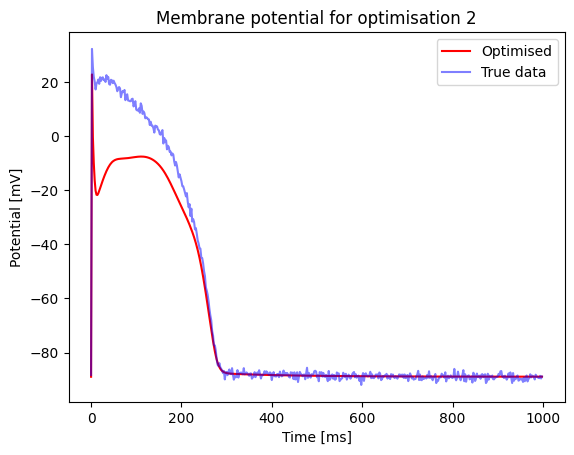

In [212]:

opt_V, opt_c = opt_soln[:, 0], opt_soln[:, 1]
noisy_V, noisy_c = noisy_data[:, 0], noisy_data[:, 1]
# opt_V = opt_soln[:, 0]
plt.plot(times, opt_V, "-r", label="Optimised")
plt.plot(times, noisy_V, "-b", alpha=0.5, label="True data")
plt.xlabel("Time [ms]")
plt.ylabel("Potential [mV]")
plt.legend()
plt.title(f"Membrane potential for optimisation {chosen_opt}")
# plt.savefig(f"optimisation_outputs/membrane_potential_na_lca_kr_cl_to_{chosen_opt}.png")

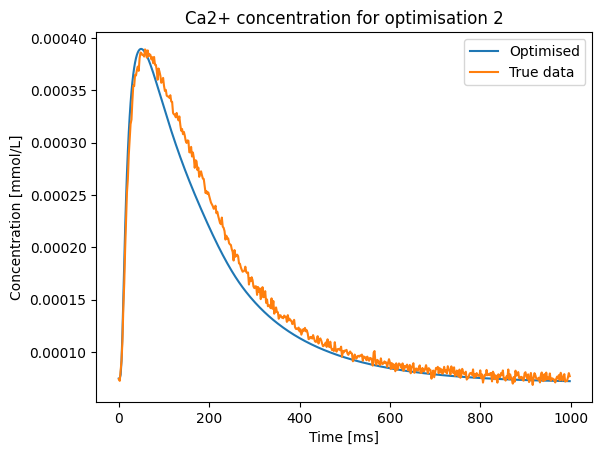

In [182]:
plt.plot(times, opt_c, label="Optimised")
plt.plot(times, noisy_c, label="True data")
plt.xlabel("Time [ms]")
plt.ylabel("Concentration [mmol/L]")
plt.legend()
plt.title(f"Ca2+ concentration for optimisation {chosen_opt}")
plt.savefig(f"optimisation_outputs/calcium_na_lca_kr_cl_to_{chosen_opt}.png")

## Inference using `pints.HaarioBardenetACMC`

### Setting up our likelihood

As with the error measure, we wish to create a custom likelihood function for the inference process. This will mimic the behaviour
of the error measure. As many of the operations are the same as the error measure, we use composition to pass a `ToRORdErrorMeasure` to
the constructor for the log likelihood, which will take the form

\begin{equation}
    L(\mathbf{G}, \mathbf{\sigma} | \mathbf{x}) = -3\log{2\pi} -\sum_{i \in I}\left[\log{\sigma_{i}} + \frac{\mathcal{E}_{i}(\mathbf{G} | \mathbf{x})}{2\pi\sigma_{i}^{2}}\right],
\end{equation}
where $\mathbf{G}$ is the vector of conductances to be inferred, $\mathbf{\sigma}$ is the vector of standard deviations for each normally distributed error term, $\mathbf{x}$ is the data vector and $I = \{APD, CaTA, CaTD, BINa, BICaL, BIK1\}$.

If we are instead using the entire action potential and calcium traces, the form of the log likelihood looks slightly different, as we are recording
data across all time steps $t$ for these measures. In this scenario,

\begin{equation}
    L(\mathbf{G}, \mathbf{\sigma} | \mathbf{x}) = -\frac{3}{2}\log{2\pi} -\sum_{i \in I_{1}}\left[\log{\sigma_{i}} + \frac{\mathcal{E}_{i}(\mathbf{G} | \mathbf{x})}{2\pi\sigma_{i}^{2}}\right] - T\left(\log{2\pi} + \sum_{i \in I_{2}}\left[\log{\sigma_{i}} + \frac{\mathcal{E}_{i}(\mathbf{G} | \mathbf{x})}{2\pi\sigma_{i}^{2}}\right]\right),
\end{equation}
where $I_{1} = \{BINa, BICaL, BIK1\}$, $I_{2} = \{APTr, CaTr\}$ and $T$ is the number of time points we evaluate on.

In [23]:
class ToRORdLogLikelihood(pints.ProblemLogLikelihood):

    def __init__(self, problem: pints.MultiOutputProblem, torord_error_measure: ToRORdErrorMeasure, metrics="biomarkers",
                 sigma=None):
        """We have a similar initialisation process to the ProblemLogLikelihood class, but we also
        include our error measure instance. We will store the number of terms (the number of error
        terms in our measure) in the function too.
        """
        super(ToRORdLogLikelihood, self).__init__(problem)
        self._torord_error_measure = torord_error_measure
        self._n_terms = torord_error_measure.n_errors()
        self._n_times = len(torord_error_measure.times())
        self._sigma = sigma

        # Here we add the number of parameters of the problem to the number of error terms to get all parameters
        # If we specify the sigma values, then we reduce the number of parameters we need to infer
        self._n_parameters = problem.n_parameters() + self._n_terms if sigma is None else problem.n_parameters()
        self._metrics = metrics

    def __call__(self, x):
        """Here we calculate the log likelihood using the different error terms.
        """
        if self._sigma is None:
            end_index = -self._n_terms
            sigma = np.asarray(x[end_index:])
        else:
            end_index = self._n_parameters
            sigma = self._sigma
        if any(sigma <= 0):
            return -np.inf
        errors = self._torord_error_measure.get_errors(x[:end_index])
        # print(errors)
        log_likelihood = -self._n_terms / 2 * np.log(2 * np.pi) - np.sum(np.log(sigma) + errors / (2 * np.pi * sigma**2))
        # print(log_likelihood)
        if self._metrics == "traces":
            log_likelihood += -(self._n_times - 1) * np.sum(np.log(2 * np.pi) / 2 + np.log(sigma[0:2]) + errors[0:2] / (2 * np.pi * sigma[0:2]**2))
        # print(log_likelihood)
        return log_likelihood

### Normalising

For our likelihood, we have control over the standard deviations, where these values are determined by the
literature for biomarkers, and determined by our chosen noise implementation for the traces. The binary conditions are chosen to have a standard deviation of $0.1$.

|Error term|Standard Deviation|Source|
|------------|-----|------------|
|$\mathcal{E}_{APD}$|66ms|Britton *et al.* pg 3[$^{[1]}$](#Sources)|
|$\mathcal{E}_{CaTA}$|20nM|Coppini *et al.* Fig. 3B Top[$^{[2]}$](#Sources)|
|$\mathcal{E}_{CaTD}$|40ms|Coppini *et al.* Fig. 3B Bottom[$^{[2]}$](#Sources)|

We also have to normalise out by the magnitudes of the true values used in the error function. This cancels out the contribution
from the original error term so that the standard deviations truly match what they are in the literature for the likelihood function.

In [24]:
sigma = np.array([66 / score.true_APD90, 20e-6 / score.true_CaTA, 40 / score.true_CaTD90, 0.1, 0.1, 0.1])

In [25]:
log_likelihood = ToRORdLogLikelihood(problem, score, sigma=sigma)

### Calculating prior and initialising chains

Our prior must also encompass guesses for the standard deviations. For the moment, we will just keep this as a `pints.TruncatedGaussianLogPrior`.

In [26]:
composed_log_prior = pints.ComposedLogPrior(log_prior,
                                            pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
                                            pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
                                            pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
                                            pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
                                            pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
                                            pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
                                           )
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Here, we initialise the chain with the optimised parameters. We only need one chain for our purpose as we use
parameters close to the true value.

In [27]:
# xs = np.tile(np.array(opt_params[chosen_opt].tolist() + [1, 1, 1, 1, 1, 1]), (1, 1))
opt_xs = opt_params[chosen_opt].tolist()
xs = np.array([opt_xs, (np.array(opt_xs) * 1.001).tolist(), (np.array(opt_xs) * 0.999).tolist()])
num_chains = 3
# transform = pints.RectangularBoundariesTransformation([1e-6, 1e-3, 1e-2, 0, 0, 0, 0, 0, 0],
#                                                       [1e-4, 1e-1, 1, 4, 4, 4, 4, 4, 4])
transform = pints.RectangularBoundariesTransformation([1, 1e-6, 1e-3, 1e-2],
                                                      [1e2, 1e-4, 1e-1, 1])

### Performing inference

In [28]:
n_params = log_prior.n_parameters()
mcmc = pints.MCMCController(log_posterior, num_chains, xs, method=pints.HaarioBardenetACMC, transformation=transform)
max_iterations = 20000
mcmc.set_max_iterations(max_iterations)

chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.3
1     6      0.5       0.5       0.5        0:00.7
2     9      0.667     0.667     0.667      0:01.0
3     12     0.75      0.5       0.75       0:01.4
20    63     0.905     0.857     0.857      0:07.0
40    123    0.951     0.854     0.902439   0:13.7
60    183    0.967     0.869     0.852459   0:20.3
80    243    0.951     0.889     0.877      0:26.8
100   303    0.941     0.901     0.891      0:33.4
120   363    0.95      0.917     0.901      0:40.0
140   423    0.957     0.915     0.908      0:46.6
160   483    0.957     0.919     0.913      0:53.2
180   543    0.961326  0.917     0.923      0:59.8
Initial phase completed.
200   603    0.965     0.920398  0.925      1:06.3


C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


220   663    0.918552  0.891     0.896      1:13.0
240   723    0.879668  0.863     0.851      1:19.8
260   783    0.831     0.812     0.793      1:26.2
280   843    0.794     0.769     0.744      1:32.6
300   903    0.751     0.730897  0.714      1:39.1
320   963    0.717     0.701     0.679      1:45.6
340   1023   0.686217  0.669     0.645      1:52.0
360   1083   0.657     0.64      0.62       1:59.0
380   1143   0.633     0.612     0.598      2:05.5
400   1203   0.603     0.591     0.571      2:12.0
420   1263   0.577     0.57      0.556      2:18.7
440   1323   0.553288  0.553288  0.54       2:25.2
460   1383   0.542     0.531     0.521      2:31.5
480   1443   0.524     0.516     0.503      2:37.9
500   1503   0.515     0.499002  0.485      2:44.4
520   1563   0.499     0.484     0.478      2:51.1
540   1623   0.482     0.468     0.466      2:57.5
560   1683   0.469     0.463     0.456328   3:04.0
580   1743   0.458     0.451     0.446      3:10.5
600   1803   0.451     0.444   

### Saving chains

In [66]:
print(chains)

[[[1.00783029e+01 8.24960093e-05 3.19210082e-02 3.95782170e-01]
  [1.21868505e+01 8.20366902e-05 3.25103231e-02 4.03710189e-01]
  [9.41130953e+00 8.46267143e-05 3.40469868e-02 4.02195616e-01]
  ...
  [4.00322773e+01 8.92985334e-05 4.21567421e-02 4.59041930e-01]
  [4.00322773e+01 8.92985334e-05 4.21567421e-02 4.59041930e-01]
  [4.00322773e+01 8.92985334e-05 4.21567421e-02 4.59041930e-01]]]


In [29]:
all_param_names = param_names
for i, chain in enumerate(chains):
    df = pd.DataFrame(chain, columns=all_param_names)
    df.to_csv(f"chain_data/na_lca_kr_cl/mult_chain_{i}.csv")

## Plots

### Recovering chains from .csv files

In [30]:
num_chains = 3
list_of_chains = []
for i in range(num_chains):
    df = pd.read_csv(f"chain_data/na_lca_kr_cl/mult_chain_{i}.csv", index_col=0)
    chain = df.to_numpy()
    list_of_chains.append(chain)
chains = np.array(list_of_chains)

### Trace plots

In [31]:
import setuptools

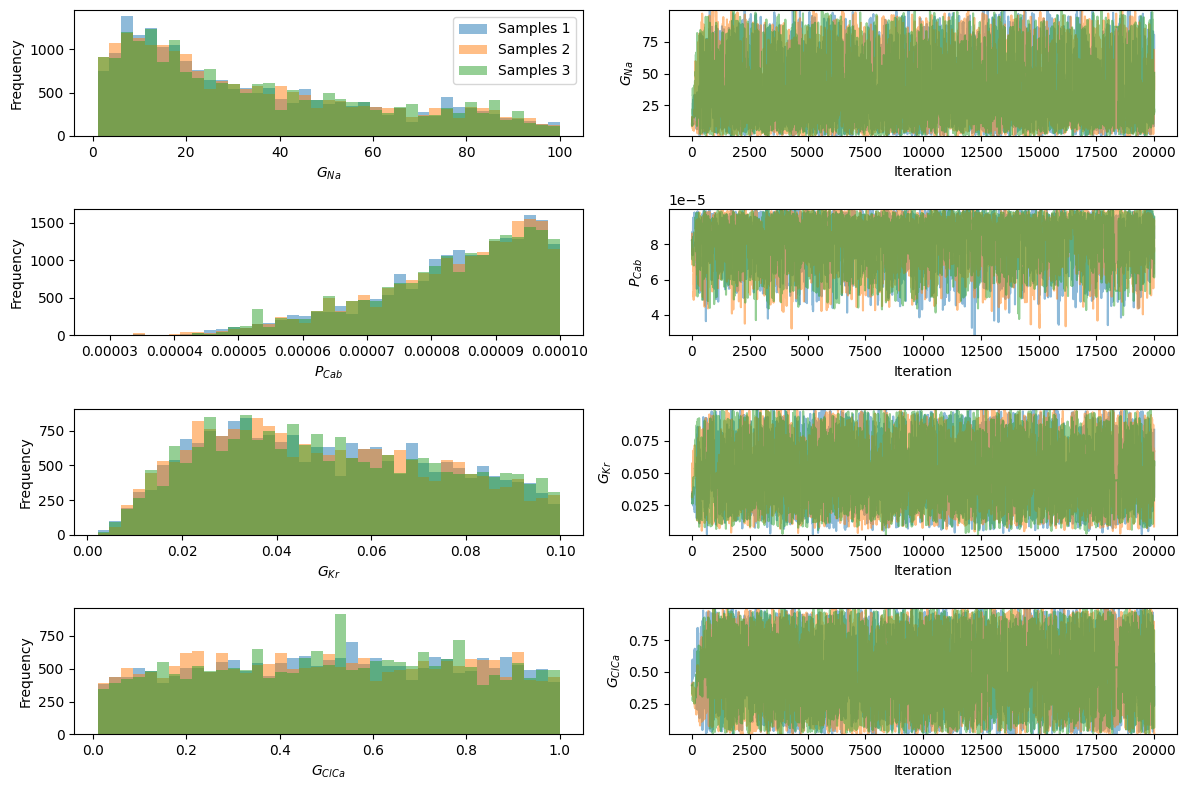

In [32]:
import pints.plot
pints.plot.trace(chains, parameter_names=all_param_names)
plt.show()

### Diagnosing using $\hat{R}$

Here we find the $\hat{R}$ measure for the inference for all different parameters. For well mixed and stationary chains, $\hat{R}$ is close to $1$.

In [33]:
r_hat_values = pints.rhat(chains, warm_up=0.5)
# all_param_names = ["P_Cab", "G_Kr", "G_ClCa"]
for i in range(len(all_param_names)):
    print(f"R_hat value for {all_param_names[i]}: {round(r_hat_values[i], 5)}")
output_param_df["R hat"] = r_hat_values

R_hat value for $G_{Na}$: 1.00075
R_hat value for $P_{Cab}$: 1.00413
R_hat value for $G_{Kr}$: 1.00091
R_hat value for $G_{ClCa}$: 1.00113


We will now discount the first part of the iterations.

In [34]:
fraction = 1 / 2
chains = chains[:, -int(fraction * max_iterations):]

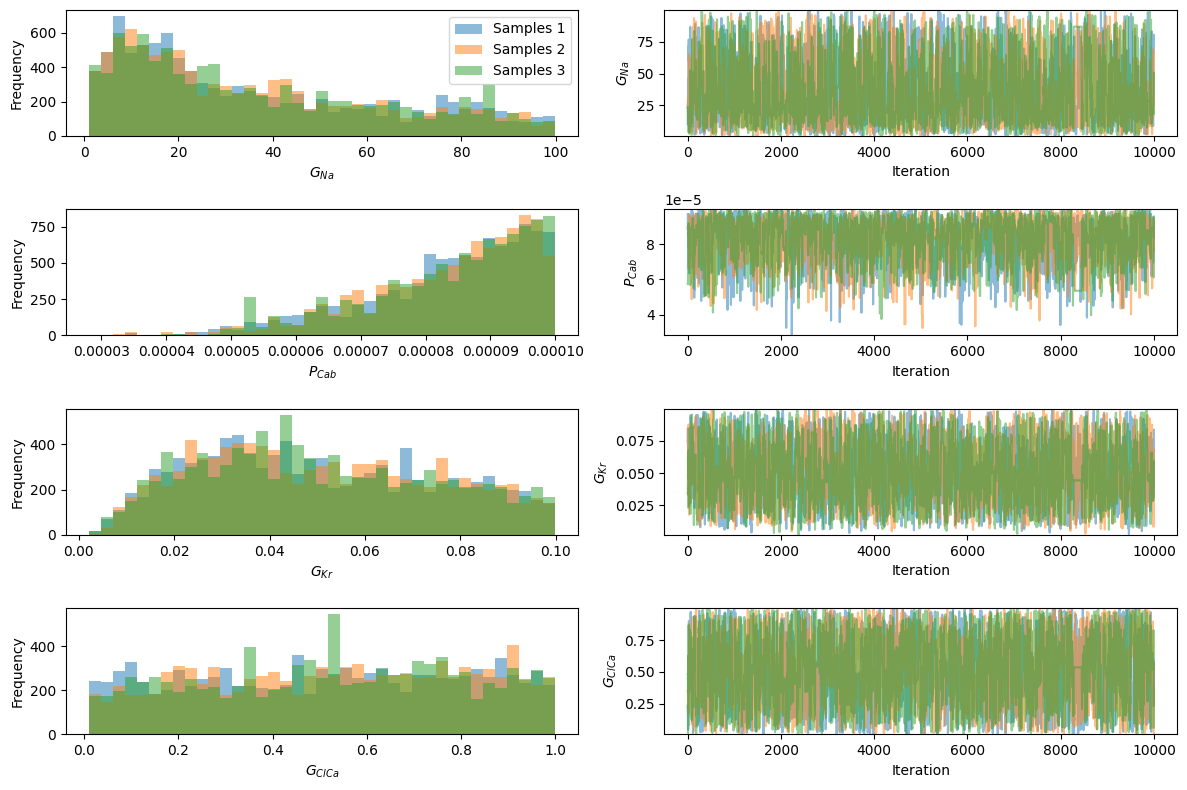

In [35]:
pints.plot.trace(chains, parameter_names=all_param_names)
plt.show()

### Predicted time series plots

#### Chain 1

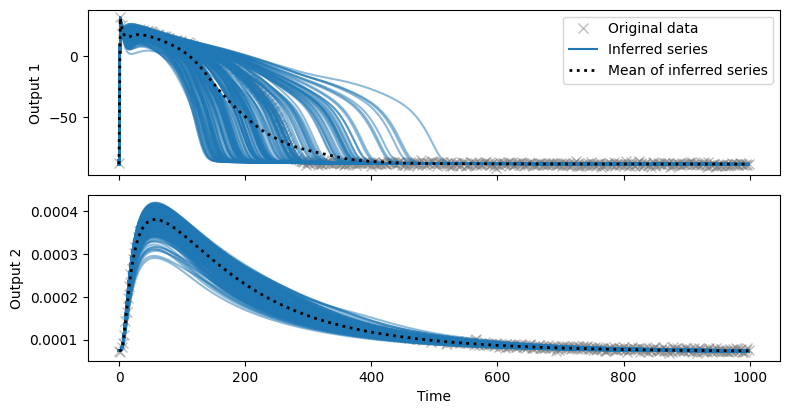

In [38]:
fig, ax = pints.plot.series(chains[0, :], problem)
plt.savefig("inference_outputs/series_lca_kr_cl_mult.png")

### Pairwise plots

Here we will see which parameters are most correlated.

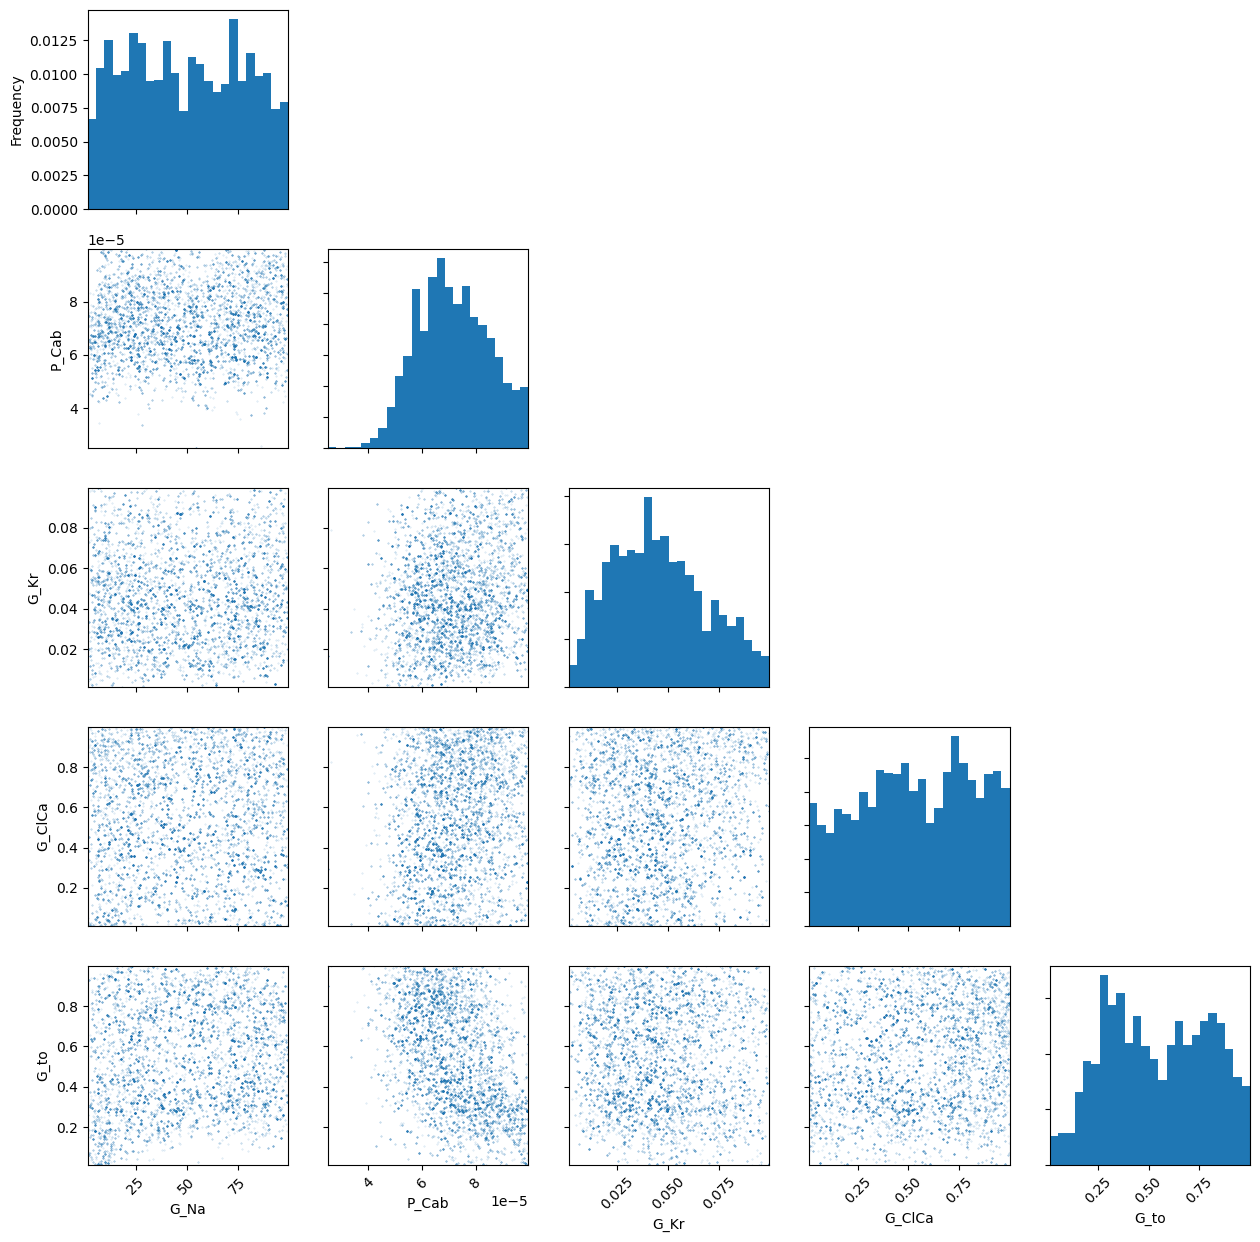

In [196]:
pints.plot.pairwise(chains[0, :], parameter_names=all_param_names)
plt.savefig("inference_outputs/pairwise_lca_kr_cl.png")

## Extracting posterior distributions

Finally, we will use the stationary chain data to extract posteriors. Assuming chains have converged, we can use their 
iterations as samples from the posterior.

In [36]:
all_param_names = model.get_unfixed_param_names()
chains_df = pd.DataFrame(columns=all_param_names + ['chain'])
for i in range(num_chains):
    chain_i_df = pd.DataFrame(chains[i], columns=all_param_names)
    chain_i_df['chain'] = [i] * len(chain_i_df)
    chains_df = pd.concat([chains_df, chain_i_df], ignore_index=True)

C:\Users\matth\AppData\Local\Temp\ipykernel_15308\2533689042.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chains_df = pd.concat([chains_df, chain_i_df], ignore_index=True)


Mean $G_{Na}$: 36.46948023974912, std dev $G_{Na}$: 27.111857200645378
Mean $P_{Cab}$: 8.339558262697119e-05, std dev $P_{Cab}$: 1.2844702785269124e-05
Mean $G_{Kr}$: 0.0502413885293518, std dev $G_{Kr}$: 0.02456818110312999
Mean $G_{ClCa}$: 0.524795891753576, std dev $G_{ClCa}$: 0.2795620445873919


IndexError: index 4 is out of bounds for axis 1 with size 4

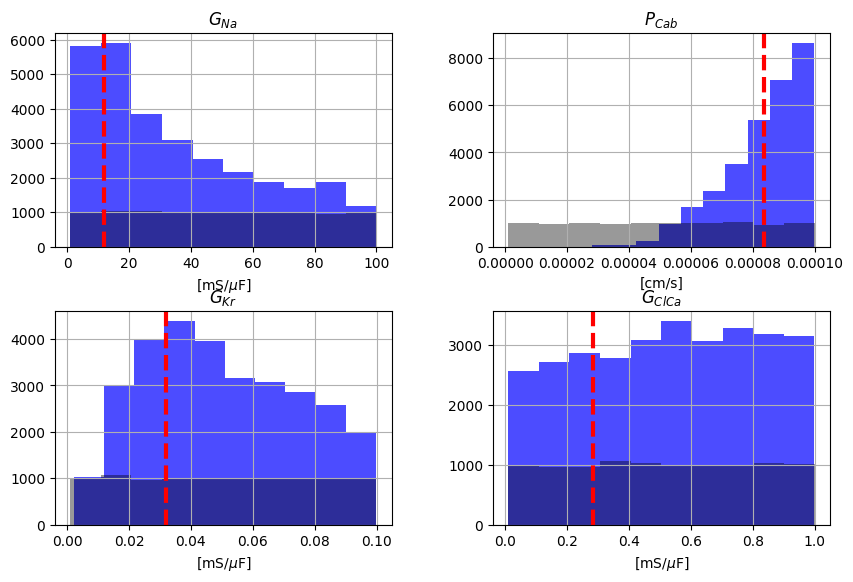

In [37]:
means = []
std_devs = []
for name in param_names:
    mean = np.mean(chains_df[name])
    std_dev = np.std(chains_df[name])
    print(f"Mean {name}: {mean}," 
          f" std dev {name}: {std_dev}")
    means.append(mean)
    std_devs.append(std_dev)
# output_param_df["Posterior mean"] = means
# output_param_df["Posterior std dev"] = std_devs
num_rows = 3
num_columns = 2
histograms = chains_df.hist(column=param_names, alpha=0.7, layout=(num_rows, num_columns), figsize=(10, 10), label="Posterior", color="blue")
num_params = len(param_names)
prior_samples = log_prior.sample(10000)
for row in range(num_rows):
    figs_in_row = num_columns
    if row == num_rows - 1:
        r = num_params % num_columns
        figs_in_row = r if r != 0 else num_params // num_rows
    for column in range(figs_in_row):
        index = row * num_columns + column
        ax = histograms[row][column]
        ax.hist(prior_samples[:, index], alpha=0.4, label="Prior", color='black')
        ax.axvline(parameters[index], color='r', linestyle='dashed', linewidth=3, label="True")
        unit = "[cm/s]" if param_names[index] == "$P_{Cab}$" else "[mS/$\\mu$F]"
        ax.set_xlabel(unit)
plt.tight_layout()
ax.legend(loc='lower right')
plt.savefig("inference_outputs/posteriors_na_lca_kr_cl_mult.png")

Finally, write all paramater information to an output file.

In [202]:
output_param_df.insert(0, "Name", all_param_names)
output_param_df.to_csv("param_info_na_lca_kr_cl_to.csv")

## Optimisation for whole action potential trace

Now we move on to optimising over the whole action potential trace.

|New error term|Model setup|Error term|Contribution to error measure|
|------------|-----|----|------------|
|Full action potential trace[$^{[1]}$](#Sources)|Default|$\mathcal{E}_{APTr}$|Normalised mean square error of whole AP trace.|
|Full calcium transient[$^{[1]}$](#Sources)|Default|$\mathcal{E}_{CaTr}$|Normalised mean square error of whole calcium transient.|

$\mathcal{E} = \mathcal{E}_{APTr} + \mathcal{E}_{CaTr} + \mathcal{E}_{BINa} + \mathcal{E}_{BICaL} + \mathcal{E}_{BIK1}$

We also normalise by the noise contributions from before for the action potential and calcium transient traces

In [41]:
output_param_Tr_df = pd.DataFrame({"true": parameters})

In [56]:
score_trace = ToRORdErrorMeasure(problem, problem_BINa, problem_BICaL, problem_BIK1, metrics="traces",
                                 normalisation=[1, 3e-6, 1, 1, 1])

In [19]:
num_opts = 10
for j in range(9, num_opts):
    xs = log_prior.sample(1)
    opt = pints.OptimisationController(score_trace, xs, boundaries=boundaries, method=pints.CMAES)
    opt.set_max_unchanged_iterations(200, 0.0000001)
    opt.set_max_iterations(1000)
    opt_params, opt_values = opt.run()
    opt_param_df = pd.DataFrame({param_names[i]: [opt_params[i]] for i in range(model.n_parameters())})
    opt_param_df.to_csv(f"optimisation_outputs/lca_kr_cl_APTr/opt_params_{j}.csv")

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Current   Time m:s
0     7      241.2968  241.2968   0:13.4
1     14     219.7589  219.7589   0:14.2
2     21     219.7589  220.148    0:14.9
3     28     219.7589  219.7753   0:15.7
20    147    197.5069  197.5069   0:28.5
40    287    2.607128  2.607128   0:43.6
60    427    2.407038  2.410067   0:58.9
80    567    2.021597  2.027506   1:14.1
100   707    2.020604  2.020608   1:29.5
120   847    2.020599  2.020599   1:44.5
140   987    2.020599  2.020599   1:59.5
160   1127   2.020599  2.020599   2:14.5
180   1267   2.020599  2.020599   2:29.8
200   1407   2.020599  2.020599   2:45.9
220   1547   2.020599  2.020599   3:03.2
240   1687   2.020599  2.020599   3:20.0
260   1827   2.020599  2.020599   3:37.0
280   1967   2.020599  2.020599   3:53.6
300   2107   2.020599  2.020599   4:10.0
320   2247   2.020599  2.020599   4:26.5
332 

In [233]:
opt_params = opt.optimiser().x_best()
import pandas as pd
opt_param_df = pd.DataFrame({param_names[i]: [opt_params[i]] for i in range(model.n_parameters())})
opt_param_df.to_csv(f"optimisation_outputs/lca_kr_cl_to_Tr/opt_params_{8}.csv")

### Plotting with optimised parameters

In [43]:
opt_params = []
num_opts = 10
for j in range(num_opts):
    opt_param_df = pd.read_csv(f"optimisation_outputs/lca_kr_cl_APTr/opt_params_{j}.csv", index_col=0)
    opt_params.append(opt_param_df.to_numpy()[0])

In [44]:
errors = []
true_error = score_trace(parameters)
print("---------------------------------------------------------------------------")
print(f"True parameters, sum of squared errors = {round(true_error, 5)}")
for j in range(num_opts):
    print("---------------------------------------------------------------------------")
    error = score_trace(opt_params[j])
    print(f"Optimisation {j}, sum of squared errors = {round(error, 5)}")
    print("---------------------------------------------------------------------------")
    errors.append(error)
    output_list = []
    for i in range(model.n_parameters()):
        opt_param = round(opt_params[j][i], 10)
        output_list.append(opt_param)
        print(f"Parameter: {param_names[i]}, True: {parameters[i]}, Optimised: {opt_param}")
    output_param_Tr_df[f"Optimisation {j}"] = output_list

---------------------------------------------------------------------------
True parameters, sum of squared errors = 2.02184
---------------------------------------------------------------------------
Optimisation 0, sum of squared errors = 2.0276
---------------------------------------------------------------------------
Parameter: $P_{Cab}$, True: 8.3757e-05, Optimised: 8.3741e-05
Parameter: $G_{Kr}$, True: 0.0321, Optimised: 0.0322195691
Parameter: $G_{ClCa}$, True: 0.2843, Optimised: 0.2710915644
---------------------------------------------------------------------------
Optimisation 1, sum of squared errors = 2.0276
---------------------------------------------------------------------------
Parameter: $P_{Cab}$, True: 8.3757e-05, Optimised: 8.37407e-05
Parameter: $G_{Kr}$, True: 0.0321, Optimised: 0.032219505
Parameter: $G_{ClCa}$, True: 0.2843, Optimised: 0.2711124701
---------------------------------------------------------------------------
Optimisation 2, sum of squared errors

In [57]:
chosen_opt = 0

In [23]:
opt_soln = model.simulate(opt_params[chosen_opt], times)

In [25]:
opt_df = pd.DataFrame(opt_soln, columns=["V", "Ca_i"])
opt_df.to_csv("optimisation_outputs/trace_data/A_trace.csv")

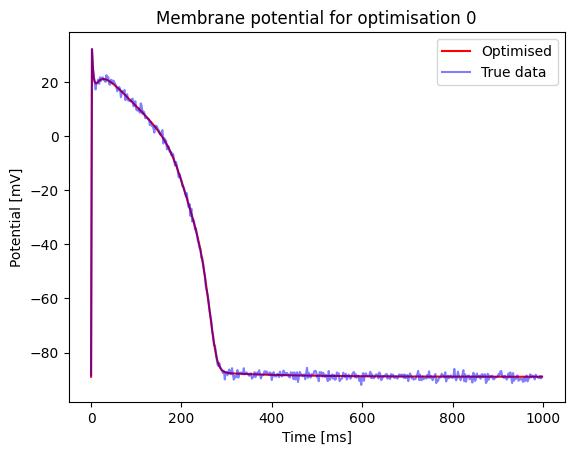

In [212]:

opt_V, opt_c = opt_soln[:, 0], opt_soln[:, 1]
noisy_V, noisy_c = noisy_data[:, 0], noisy_data[:, 1]
# opt_V = opt_soln[:, 0]
plt.plot(times, opt_V, "-r", label="Optimised")
plt.plot(times, noisy_V, "-b", alpha=0.5, label="True data")
plt.xlabel("Time [ms]")
plt.ylabel("Potential [mV]")
plt.legend()
plt.title(f"Membrane potential for optimisation {chosen_opt}")
plt.savefig(f"optimisation_outputs/membrane_potential_na_lca_kr_cl_to_Tr_{chosen_opt}.png")

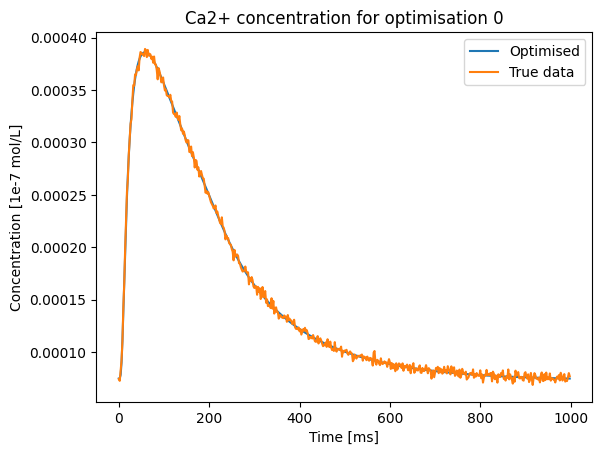

In [213]:
plt.plot(times, opt_c, label="Optimised")
plt.plot(times, noisy_c, label="True data")
plt.xlabel("Time [ms]")
plt.ylabel("Concentration [1e-7 mol/L]")
plt.legend()
plt.title(f"Ca2+ concentration for optimisation {chosen_opt}")
plt.savefig(f"optimisation_outputs/calcium_na_lca_kr_cl_to_Tr_{chosen_opt}.png")

In [58]:
sigma = np.array([1, 1, 0.1, 0.1, 0.1])

In [59]:
log_likelihood = ToRORdLogLikelihood(problem, score_trace, sigma=sigma, metrics="traces")

### Calculating prior and initialising chains

We will have stricter boundaries for this, as the posterior will be a lot narrower.

In [60]:
boundaries = pints.RectangularBoundaries([5e-5, 1e-2, 0.1],
                                         [1e-4, 5e-2, 0.5])
log_prior = pints.UniformLogPrior(boundaries)

C:\Users\matth\AppData\Local\Temp\ipykernel_4424\1416071791.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(boundaries)


In [61]:
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Here, we initialise the chain with the optimised parameters. We only need one chain for our purpose as we use
parameters close to the true value.

In [62]:
# xs = np.tile(np.array(opt_params[chosen_opt].tolist() + [1, 1, 1, 1, 1, 1]), (1, 1))
opt_xs = opt_params[chosen_opt].tolist()
xs = np.array([opt_xs, (np.array(opt_xs) * 1.001).tolist(), (np.array(opt_xs) * 0.999).tolist()])
num_chains = 3
# transform = pints.RectangularBoundariesTransformation([1e-6, 1e-3, 1e-2, 0, 0, 0, 0, 0, 0],
#                                                       [1e-4, 1e-1, 1, 4, 4, 4, 4, 4, 4])
transform = pints.RectangularBoundariesTransformation([5e-5, 1e-2, 0.1],
                                                      [1e-4, 5e-2, 0.5])

## Performing inference

In [63]:
print(log_posterior(opt_params[chosen_opt]))
print(log_posterior(parameters))

-1062.0999406751114
-1061.6418856315206


In [64]:
n_params = log_prior.n_parameters()
mcmc = pints.MCMCController(log_posterior, num_chains, xs, method=pints.HaarioBardenetACMC, transformation=transform)
max_iterations = 20000
mcmc.set_max_iterations(max_iterations)

chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.3
1     6      0         0         0          0:00.6
2     9      0         0.333     0          0:00.9
3     12     0         0.5       0          0:01.3
20    63     0.0476    0.0952    0          0:06.5
40    123    0.0732    0.0488    0          0:12.7
60    183    0.082     0.0492    0.0164     0:18.8
80    243    0.111     0.0617    0.0247     0:25.0
100   303    0.0891    0.0792    0.0495     0:31.0
120   363    0.0826    0.0744    0.0744     0:37.0
140   423    0.0709    0.0638    0.0638     0:43.0
160   483    0.0807    0.0683    0.0683     0:49.1
180   543    0.0718    0.0663    0.0718     0:55.2
Initial phase completed.
200   603    0.0746    0.0746    0.0697     1:01.2
220   663    0.127     0.118     0.118      1:07.3
240   723    0.141     0.145     0.145      1:13.4
260   783   

In [65]:
all_param_names = param_names
for i, chain in enumerate(chains):
    df = pd.DataFrame(chain, columns=all_param_names)
    df.to_csv(f"chain_data/lca_kr_cl_Tr/mult_chain_{i}.csv")

## Plots

### Recovering from .csv files

In [66]:
num_chains = 3
list_of_chains = []
for i in range(num_chains):
    df = pd.read_csv(f"chain_data/lca_kr_cl_Tr/mult_chain_{i}.csv", index_col=0)
    chain = df.to_numpy()
    list_of_chains.append(chain)
chains = np.array(list_of_chains)

### Trace plots

In [67]:
import setuptools
import pints.plot

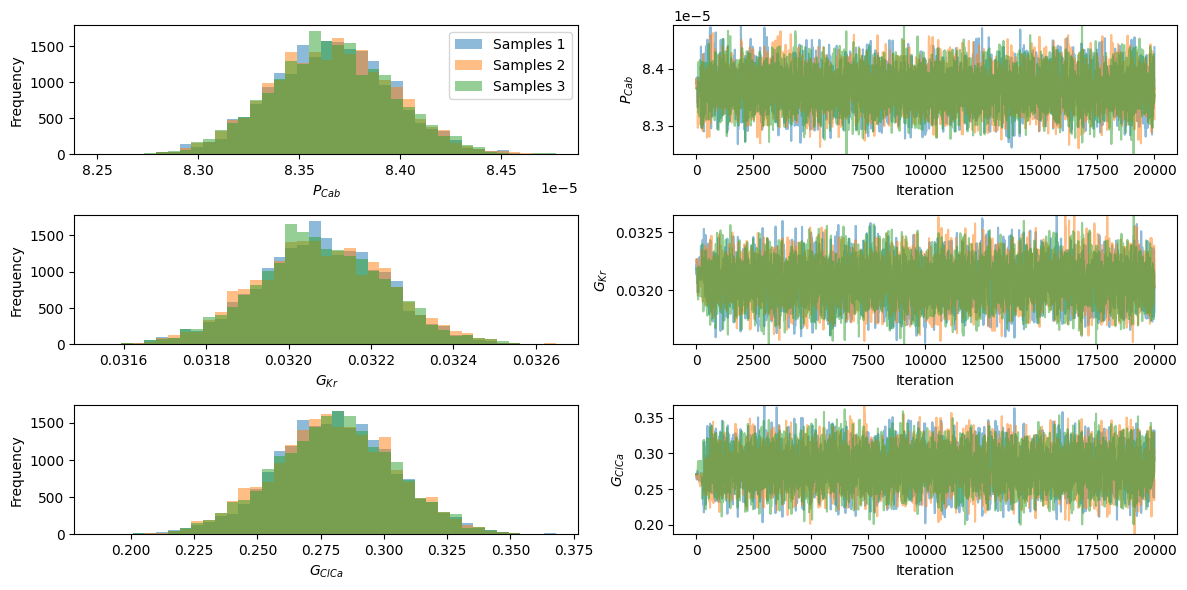

In [68]:
import pints.plot
pints.plot.trace(chains, parameter_names=all_param_names)
plt.show()

### Diagnosing using $\hat{R}$

Here we find the $\hat{R}$ measure for the inference for all different parameters. For well mixed and stationary chains, $\hat{R}$ is close to $1$.

In [69]:
all_param_names = model.get_unfixed_param_names()
r_hat_values = pints.rhat(chains, warm_up=0.5)
for i in range(len(all_param_names)):
    print(f"R_hat value for {all_param_names[i]}: {round(r_hat_values[i], 5)}")
output_param_Tr_df["R hat"] = r_hat_values

R_hat value for $P_{Cab}$: 1.00119
R_hat value for $G_{Kr}$: 1.0004
R_hat value for $G_{ClCa}$: 1.00034


We will now discount the first part of the iterations.

In [70]:
max_iterations = 20000
fraction = 1 / 2
chains = chains[:, -int(fraction * max_iterations):]

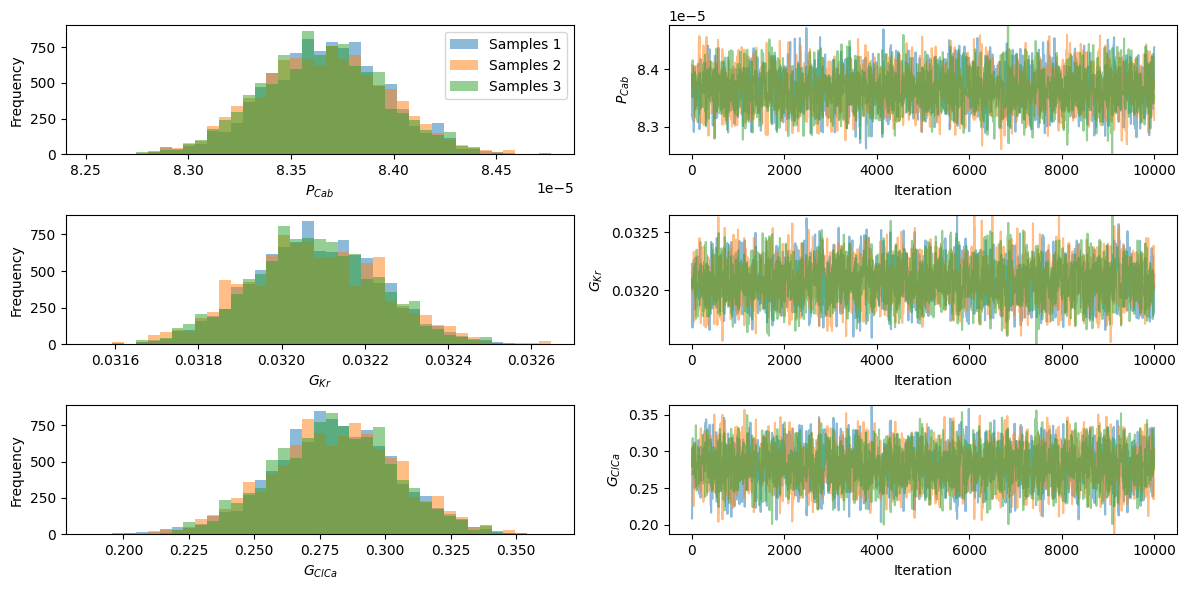

In [71]:
pints.plot.trace(chains, parameter_names=all_param_names)
plt.show()

### Predicted time series plots

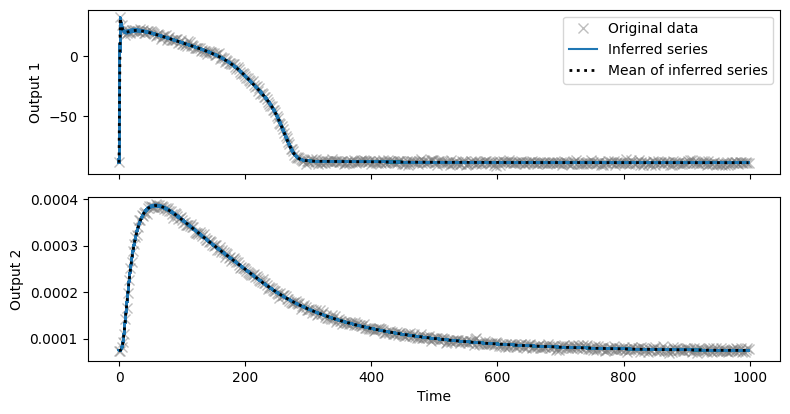

In [72]:
pints.plot.series(chains[0, :], problem)
plt.savefig("inference_outputs/series_lca_kr_cl_Tr_mult.png")

### Pairwise plots

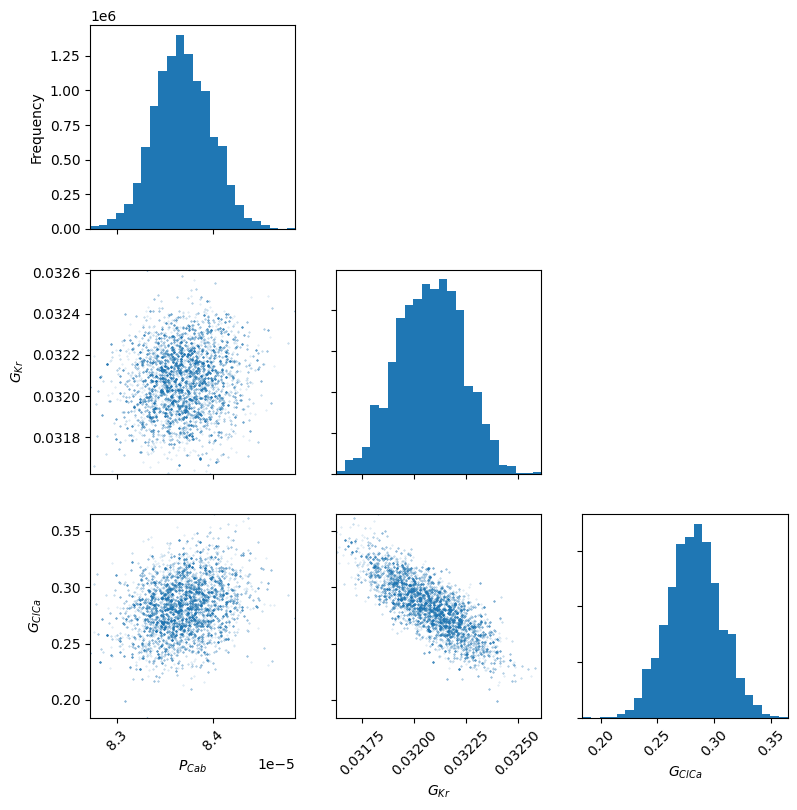

In [43]:
pints.plot.pairwise(chains[0], parameter_names=all_param_names)
plt.savefig("inference_outputs/pairwise_lca_kr_cl_Tr.png")

## Extracting posterior distributions

Finally, we will use the stationary chain data to extract posteriors. Assuming chains have converged, we can use their 
iterations as samples from the posterior.

In [73]:
chains_df = pd.DataFrame(columns=param_names + ['chain'])
for i in range(num_chains):
    chain_i_df = pd.DataFrame(chains[i], columns=param_names)
    chain_i_df['chain'] = [i] * len(chain_i_df)
    chains_df = pd.concat([chains_df, chain_i_df], ignore_index=True)

C:\Users\matth\AppData\Local\Temp\ipykernel_4424\1907700405.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chains_df = pd.concat([chains_df, chain_i_df], ignore_index=True)


Mean $P_{Cab}$: 8.365912904630732e-05, std dev $P_{Cab}$: 3.022226926602036e-07
Mean $G_{Kr}$: 0.032078710904016476, std dev $G_{Kr}$: 0.0001581143108963102
Mean $G_{ClCa}$: 0.2804472054757077, std dev $G_{ClCa}$: 0.023835408333276572


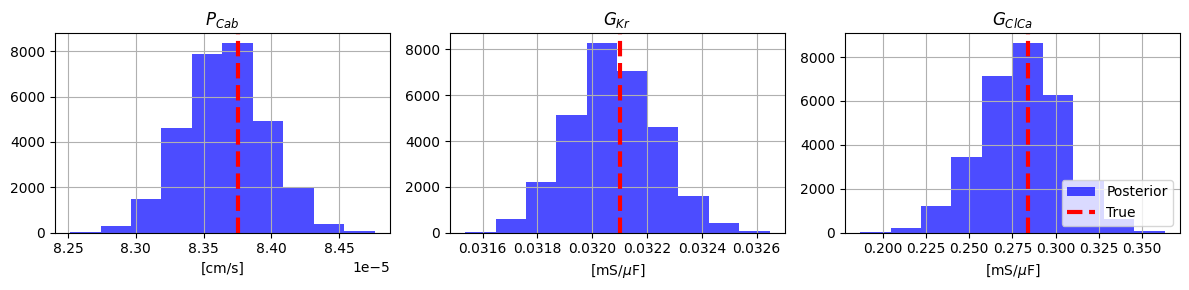

In [74]:
means = []
std_devs = []
for name in param_names:
    mean = np.mean(chains_df[name])
    std_dev = np.std(chains_df[name])
    print(f"Mean {name}: {mean}," 
          f" std dev {name}: {std_dev}")
    means.append(mean)
    std_devs.append(std_dev)
output_param_Tr_df["Posterior mean"] = means
output_param_Tr_df["Posterior std dev"] = std_devs
num_rows = 1
num_columns = 3
histograms = chains_df.hist(column=param_names, alpha=0.7, layout=(num_rows, num_columns), figsize=(12, 3), label="Posterior", color="blue")
num_params = len(param_names)
prior_samples = log_prior.sample(10000)
for row in range(num_rows):
    figs_in_row = num_columns
    if row == num_rows - 1:
        r = num_params % num_columns
        figs_in_row = r if r != 0 else num_params // num_rows
    for column in range(figs_in_row):
        index = row * num_columns + column
        ax = histograms[row][column]
        # ax.hist(prior_samples[:, index], alpha=0.4, label="Prior", color='black')
        ax.axvline(parameters[index], color='r', linestyle='dashed', linewidth=3, label="True")
        unit = "[cm/s]" if param_names[index] == "$P_{Cab}$" else "[mS/$\\mu$F]"
        ax.set_xlabel(unit)
plt.tight_layout()
ax.legend(loc='lower right')
plt.savefig("inference_outputs/posteriors_lca_kr_cl_Tr_mult.png")

In [48]:
# output_param_Tr_df.insert(0, "Name", param_names)
output_param_Tr_df.to_csv("param_info_lca_kr_cl_Tr.csv")

## Sources

$^{[1]}$ J. Tomek *et al.*, Development, calibration, and validation of a novel human ventricular myocyte model in health, disease, and drug block, eLife **8** (2019), e48890, https://doi.org/10.7554/eLife.48890.

$^{[2]}$ E. Grandi *et al.*, A Novel Computational Model of the Human Ventricular Action Potential and Ca Transient, J. Mol. Cell Cardiol. **48** (2010), pp. 112, https://pubmed.ncbi.nlm.nih.gov/19835882/.

$^{[3]}$ T. O’Hara *et al.*, Simulation of the Undiseased Human Cardiac Ventricular Action Potential: Model Formulation and Experimental 
Validation, PLoS Comput. Biol.** **7 (2011), e100206, https://doi.org/10.1371/journal.pcbi.10020611.

$^{[4]}$ Y. Lu *et al.*, Effects of premature stimulation on HERG K+ channels **537** (2001), pp. 843-851, https://pubmed.ncbi.nlm.nih.gov/11744759/.

$^{[5]}$ J. Tomek, Repository for the cardiac model ToR-ORd, Github, 4ffab13, https://github.com/jtmff/torord. Date first accessed: 2024-04-22. 